# BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [131]:
cptac.download(dataset='renalccrcc')

All files already downloaded and correct.


True

In [195]:
re = cptac.RenalCcrcc()
proteomics = re.get_proteomics()
transcriptomics = re.get_transcriptomics()
clinical = re.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [197]:
clinical['histologic_type'].value_counts()

Clear cell renal cell carcinoma        103
non-Clear Cell renal cell carcinoma      7
Name: histologic_type, dtype: int64

In [198]:
#Data cleaning. We want to get rid of non_clear cell carcinoma, 
#as it throws off our analysis, and isn't what we are studying
non_clear_cell_filter = clinical['histologic_type'] == 'non-Clear Cell renal cell carcinoma'
clinical = clinical[~non_clear_cell_filter]

In [199]:
#We also need to get rid of those samples in the datasets we plan to use. In this case, Proteomics.
rows_to_drop = []

for i, item in enumerate(proteomics.index):
    if item not in list(clinical.index):
        rows_to_drop.append(item)
proteomics.drop(rows_to_drop)

,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,AADAT,AAED1,AAGAB,...,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,-0.304302,0.641447,-0.000025,NaN,0.207831,-0.364128,NaN,-1.203886,-0.217934,0.216894,...,-0.064343,NaN,-0.094441,NaN,NaN,-0.021827,0.133927,0.237280,0.114409,NaN
S002,1.195915,0.194620,1.360294,NaN,0.126956,-0.572843,NaN,-1.596546,NaN,0.221696,...,0.112064,NaN,0.072262,NaN,NaN,-0.205642,0.182434,NaN,0.201374,-0.068340
S003,-0.286155,-0.780455,-0.101089,NaN,0.292629,0.035812,NaN,NaN,NaN,0.300863,...,0.136957,NaN,0.279732,0.695116,NaN,0.316298,-0.009772,-0.019653,-0.095339,0.008961
S004,0.135730,0.404286,0.261384,NaN,0.155568,0.336311,NaN,NaN,0.709046,0.244198,...,-0.013139,NaN,0.157541,0.526188,NaN,-0.120501,0.054559,-0.313236,0.062194,0.052825
S005,-0.123959,-0.677773,-0.362547,NaN,0.187605,-0.320026,NaN,-1.300148,-0.153216,0.229676,...,-0.058953,NaN,0.152341,0.072886,0.068182,NaN,0.178869,0.266290,-0.028647,0.003682
S006,0.427542,0.310249,1.308011,NaN,0.121887,-0.065935,NaN,NaN,NaN,-0.181108,...,0.061067,NaN,-0.165764,0.037879,0.999285,0.506016,0.126186,-0.511375,0.096536,0.118995
S007,-0.242107,-0.128732,-0.256201,NaN,0.240502,-0.111920,NaN,NaN,NaN,0.316923,...,-0.034356,NaN,0.026148,NaN,0.604814,NaN,0.143593,0.064460,0.023557,NaN
S008,0.506469,-0.513243,-0.495248,NaN,0.135256,-0.221287,NaN,-1.378737,0.009520,-0.085217,...,-0.053394,NaN,-0.199343,NaN,NaN,0.132632,0.097875,0.236196,-0.009806,NaN
S009,0.720836,-1.135859,0.488708,NaN,0.204237,-0.269864,NaN,NaN,NaN,0.071889,...,-0.203664,NaN,-0.073061,0.160854,NaN,0.598381,0.150426,0.121793,-0.044642,-0.108791


In [200]:
#Create a copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical.copy())

In [201]:
#Convert columns that should be numeric to numeric
annotations['age'] = annotations['age'].replace('>=90', 90)
annotations['age'] = pd.to_numeric(annotations['age'])

annotations['age_started_smoking'] = annotations['age_started_smoking'].replace('Unknown', np.nan)
annotations['age_started_smoking'] = pd.to_numeric(annotations['age_started_smoking'])

annotations['age_stopped_smoking'] = annotations['age_stopped_smoking'].replace('Unknown', np.nan)
annotations['age_stopped_smoking'] = pd.to_numeric(annotations['age_stopped_smoking'])

annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'].replace('Unknown', np.nan)
annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = pd.to_numeric(annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'])

In [202]:
#Drop irrelevant columns
irrelevant_cols = ['Patient_ID', 'height_in_cm', 'weight_in_kg', 'race', 'ethnicity', 
                   'ethnicity_self_identified','tumor_site_other', 'sarcomatoid_features', 
                   'pathologic_findings_in_nonneoplastic_kidney_specify', 
                   'other_immunohistochemistry_specify', 'other_testing_performed', 
                   'other_coagulopathies', 'exposure_to_secondhand_smoke', 
                   'tumor_tissue_collection_clamps_used','tumor_tissue_collection_frozen_with_OCT', 
                   'preoperative_IV_sedation_administered',  'preoperative_IV_opiates_administered', 
                   'preoperative_IV_antiemetics_administered','preoperative_IV_anti_acids_administered', 
                   'other_preoperative_IV_medications_administered', 'platelets',
                   'local_anesthesia_agents_administered', 'regional_anesthesia_agents_administered', 
                   'IV_anesthesia_agents_administered', 'IV_narcotic_opiate_agents_administered', 
                   'IV_muscle_relaxants_administered', 'inhalation_anesthesia_agents_administered', 
                   'additional_anesthesia', 'other_medications_administered_during_surgery', 
                   'surgical_procedure', 'epochs_of_oxygen_desaturation', 'time_specimen_left_OR', 
                   'first_participant_temperature_recorded_in_OR', 'first_temperature_recorded_in_OR_units', 
                   'first_temperature_recorded_in_OR_celsius', 'time_of_first_temperature', 
                   'first_temperature_recorded_in_OR_fahrenheit', 'second_participant_temperature_recorded_in_OR', 
                   'second_temperature_recorded_in_OR_units','second_temperature_recorded_in_OR_celsius', 
                   'second_temperature_recorded_in_OR_fahrenheit', 'time_of_second_temperature', 
                   'Karnofsky_score_at_12months_follow_up', 'Karnofsky_score_at_24months_follow_up', 
                   'performance_status_scale_timing_at_12months_follow_up', 
                   'performance_status_scale_timing_at_24months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_24months_follow_up',  
                   'adjuvant_postoperative_immunological_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_immunological_therapy_at_24months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_24months_follow_up', 
                   'ECOG_score_at_12months_follow_up', 'ECOG_score_at_24months_follow_up', 
                   'specimen_id', 'slide_id', 'Presence_sarcomatoid_features', 
                   'non_cellular_component_description', 'meets_required_criteria', 
                   'histologic_type_of_normal_tissue', 'findings_not_consistent_with_local_pathology_report', 
                   'minutes_clamp_1_to_collection', 'minutes_clamp_2_to_collection', 
                   'consistent_with_diagnostic_report', 'patient_medications']

annotations = annotations.drop(irrelevant_cols, axis=1)

#Columns we should either drop, or be generally skeptical of in our analysis
questionable_cols = ['specify_distant_metastasis_documented_sites', 
                     'erythrocyte_sedimentation_rate', 
                     'renal_vein_or_vena_cava_thrombosis', 
                     'CO2_level_recorded_at_time_closest_to_organ_excision']

annotations = annotations.drop(questionable_cols, axis=1)

In [203]:
#Determine which columns are binary and which aren't
binary_cols = []
non_binary_cols = []

for col in annotations.columns:
    #this is the number of datapoints in a column
    if annotations[col].describe()[0] <= 10:
        annotations = annotations.drop(col, axis=1)
    elif len(annotations[col].value_counts()) == 2:
        binary_cols.append(col)
    elif len(annotations[col].value_counts()) > 2:
        non_binary_cols.append(col)
    else:
        annotations = annotations.drop(col, axis=1)

numeric_non_bin = []
categorical_non_bin = []

for item in non_binary_cols:
    if np.issubdtype(annotations[item].dtype, np.number):
        numeric_non_bin.append(item)
        mean = annotations[item].mean()
        annotations[item]= bf.binarizeCutOff(annotations, item, mean, 
                                             "Above_Mean("+str(round(mean, 2))+")", 
                                             "Below_Mean("+str(round(mean, 2))+")")
    else:
        categorical_non_bin.append(item)

## Step 2a: Binarize column values

In [204]:
tumor_site_map = {'Other':'Other',
                  'Upper pole':'Pole',
                  'Middle':'Pole',
                  'Lower pole':'Pole'}

annotations['tumor_site'] = bf.binarizeCategorical(annotations,
                                                   'tumor_site',
                                                   tumor_site_map)

In [205]:
histologic_grade_map = {'G1':'G1or2',
                        'G2':'G1or2',
                        'G3':'G3or4',
                        'G4':'G3or4'}

annotations['histologic_grade'] = bf.binarizeCategorical(annotations, 
                                                         'histologic_grade',
                                                         histologic_grade_map)

In [206]:
tumor_stage_pathological_map = {'Stage I':'StageIorII', 
                                'Stage II':'StageIorII', 
                                'Stage III':'StageIIIorIV',
                                'Stage V':'StageIIIorV'}

annotations['tumor_stage_pathological'] = bf.binarizeCategorical(annotations,
                                                                 'tumor_stage_pathological',
                                                                 tumor_stage_pathological_map)

In [207]:
pathologic_staging_map = {'pT3a':'pT3or4', 
                          'pT1a':'pT1or2', 
                          'pT1b':'pT1or2', 
                          'pT2a':'pT1or2', 
                          'pT2b':'pT1or2', 
                          'pT3':'pT3or4', 
                          'pT3b':'pT3or4', 
                          'pT4':'pT3or4'}

annotations['pathologic_staging_primary_tumor_pT'] = bf.binarizeCategorical(annotations,
                                                                            'pathologic_staging_primary_tumor_pT',
                                                                            pathologic_staging_map)

In [208]:
pathologic_lymph_map = {'pNX':'pNX', 
                        'pN0':'pN0or1', 
                        'pN1':'pN0or1'}

annotations['pathologic_staging_regional_lymph_nodes_pN'] = bf.binarizeCategorical(annotations,
                                                                                   'pathologic_staging_regional_lymph_nodes_pN',
                                                                                   pathologic_lymph_map)

In [209]:
pathologic_metastasis_map = {'Staging Incomplete':np.nan,
                             'No pathologic evidence of distant metastasis':'No',
                             'pM1':'pM1'}

annotations['pathologic_staging_distant_metastasis_pM'] = bf.binarizeCategorical(annotations,
                                                                                 'pathologic_staging_distant_metastasis_pM',
                                                                                 pathologic_metastasis_map)

In [210]:
annotations['clinical_staging_distant_metastasis_cM'] = annotations['clinical_staging_distant_metastasis_cM'].replace('Staging Incomplete', np.nan)

In [211]:
serum_calcium_map = {'Not evaluated':np.nan,
                     'Unknown':np.nan,
                     'Normal':'Normal',
                     'Low':'Abnormal',
                     'Elevated':'Abnormal'}

annotations['serum_calcium'] = bf.binarizeCategorical(annotations,
                                                      'serum_calcium',
                                                      serum_calcium_map)

In [212]:
hemoglobin_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['hemoglobin'] = bf.binarizeCategorical(annotations,
                                                   'hemoglobin',
                                                   hemoglobin_map)

In [213]:
white_cell_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['white_cell_count'] = bf.binarizeCategorical(annotations,
                                                         'white_cell_count',
                                                         white_cell_map)

In [214]:
country_map = {'United States':'US', 
               'Poland':'Other',
               'Other':'Other', 
               'Ukraine':'Other',
               'Vietnam':'Other'}

annotations['participant_country_of_origin'] = bf.binarizeCategorical(annotations,
                                                                      'participant_country_of_origin',
                                                                      country_map)

In [215]:
annotations['margin_status'] = annotations['margin_status'].replace('Cannot be assessed', np.nan)

In [216]:
annotations['residual_tumor'] = annotations['residual_tumor'].replace('RX:Presence of residual tumor cannot be assessed', np.nan)

In [217]:
annotations['other_immunohistochemistry_performed'] = annotations['other_immunohistochemistry_performed'].replace('Unknown', np.nan)

In [218]:
alcohol_map = {'Lifelong non-drinker':'Non-drinker',
               'Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women':'Previous_or_Current_Drinker',
               'Alcohol consumption history not available':np.nan,
               'Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women':'Previous_or_Current_Drinker',
               'Consumed alcohol in the past, but currently a non-drinker':'Previous_or_Current_Drinker'}

annotations['alcohol_consumption'] = bf.binarizeCategorical(annotations, 
                                                            'alcohol_consumption', 
                                                            alcohol_map)

In [219]:
tobacco_map = {'Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime':'Non-smoker', 
               'Smoking history not available':np.nan, 
               'Current reformed smoker within past 15 years':'Non-smoker', 
               'Current smoker: Includes daily and non-daily smokers':'Current Smoker', 
               'Current reformed smoker, more than 15 years':'Non-smoker'}

annotations['tobacco_smoking_history'] = bf.binarizeCategorical(annotations, 
                                                                'tobacco_smoking_history', 
                                                                tobacco_map)

In [220]:
annotations['tumor_status_at_12months_follow_up'] = annotations['tumor_status_at_12months_follow_up'].replace('Unknown', np.nan)

In [221]:
annotations['tumor_status_at_24months_follow_up'] = annotations['tumor_status_at_24months_follow_up'].replace('Unknown', np.nan)

In [222]:
success_map1 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_initial_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_12months_follow_up', 
                                                                                           success_map1)

In [223]:
success_map2 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_initial_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_24months_follow_up', 
                                                                                           success_map1)

In [224]:
success_map3 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_12months_follow_up',
                                                                                   success_map3)

In [225]:
success_map4 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_24months_follow_up',
                                                                                   success_map4)

In [226]:
annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'].replace('Unknown', np.nan)

In [227]:
annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'].replace('Unknown', np.nan)

## Step 3: Perform outliers analysis

In [228]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)                                        

In [229]:
#Get only the outliers. The second half of index is the _notOutliers, which we don't need
length = int(len(outliers_prot.index) / 2)
short_outliers = outliers_prot[:length]
outlier_dict = {}
for i in range(len(short_outliers)):
    key = list(proteomics.index)[i]
    my_filter = short_outliers.iloc[i] == 1.0
    value = list(short_outliers.iloc[i][my_filter].index)
    outlier_dict[key] = value
    print('Key:', key)
    print('Value:', value)
    print('\n')

Key: S001
Value: ['AAMP', 'AARSD1', 'ADRM1', 'AIP', 'ALDH1A1', 'ANAPC13', 'ARAF', 'ARFGAP3', 'ARMC6', 'ATG12', 'ATG3', 'ATG5', 'ATP13A3', 'BABAM1', 'BBS12', 'BLMH', 'BROX', 'C12orf29', 'CAMKMT', 'CASP7', 'CCT2', 'CCT4', 'CCT5', 'CCT6A', 'CCT7', 'CCT8', 'CDC16', 'CDC23', 'CDK6', 'CHMP2A', 'CIAO1', 'CIDEB', 'CLIC1', 'COPS5', 'CSNK2B', 'DCTN5', 'DCTN6', 'DCUN1D1', 'DNALI1', 'EIF2B2', 'EIF2B3', 'EIF2B5', 'EIF3E', 'EIF4E3', 'EIF6', 'ERCC2', 'FAM168A', 'FBXO3', 'FBXW2', 'FBXW5', 'FBXW9', 'FTO', 'G6PD', 'GART', 'GBE1', 'GBF1', 'GDPGP1', 'GTF3C5', 'HDAC3', 'HDGF', 'HEBP2', 'HINT1', 'HLA-DRB5', 'HNF1B', 'HSP90AB1', 'HUS1', 'IFT140', 'IPO4', 'KIAA1107', 'KIF1BP', 'KIF3A', 'KIF3B', 'LRSAM1', 'LTA4H', 'MAF1', 'MAK16', 'MAP2K7', 'MBTD1', 'MOB3B', 'MRNIP', 'MTR', 'MTRR', 'MYO18A', 'NANS', 'NCOR1', 'NEDD9', 'NME7', 'NMT1', 'NPR3', 'NSF', 'NT5DC1', 'NUBP2', 'NUDT5', 'NUP88', 'OTUB1', 'PBDC1', 'PCBP2', 'PCM1', 'PDK4', 'PGGT1B', 'PGM3', 'PHYKPL', 'PIK3AP1', 'PIK3CB', 'PIN1', 'POLR2I', 'POP4', 'PPIP5K2',

Key: S005
Value: ['ADAMTS1', 'AKAP11', 'ANKHD1', 'ANKLE2', 'ANKMY2', 'APOL2', 'ARF4', 'ASNS', 'BAALC', 'BCCIP', 'BMP1', 'C8orf33', 'CADM3', 'CASP7', 'CBS', 'CD38', 'CDK1', 'CEP128', 'CEP55', 'CHORDC1', 'CIAO2B', 'CKAP5', 'COL6A1', 'COL7A1', 'CPE', 'CSE1L', 'CYB5R4', 'DBNL', 'DDX21', 'DFFA', 'DHCR24', 'DNAJC7', 'ECE1', 'ECPAS', 'EEF1A1', 'EEF1D', 'EEF2', 'EIF2S1', 'EIF2S2', 'EIF2S3', 'EIF3D', 'EIF3I', 'EIF5', 'ERRFI1', 'F3', 'FAM208A', 'FAM50A', 'FBN3', 'FLNC', 'FOXP1', 'FRA10AC1', 'FXR1', 'GBF1', 'GDF6', 'GLS', 'GMPS', 'GPX7', 'HECTD1', 'HGH1', 'HSP90AB1', 'HSPBP1', 'HTRA3', 'IFRD2', 'IMPDH2', 'INA', 'INHBA', 'IRS2', 'KCNMA1', 'KIF1BP', 'KPNA2', 'LARP1', 'LMCD1', 'LOXL1', 'LRCH3', 'MAGED1', 'MAP4', 'MBD4', 'MICAL1', 'MKI67', 'MLPH', 'MMS19', 'NAV1', 'NBEAL2', 'NCAPD2', 'NCKIPSD', 'NEFL', 'NEFM', 'NUDC', 'NUDCD1', 'NUF2', 'OGFOD3', 'OXR1', 'P3H3', 'P3H4', 'PCNA', 'PEG10', 'PGF', 'PJA2', 'PKP3', 'PLAUR', 'PLEK2', 'POP1', 'PTGES', 'PTPN14', 'RAB6D', 'RACGAP1', 'RASGRP1', 'RCL1', 'RFC4', '

Value: ['AARS', 'ABCG2', 'ABL2', 'ADAMTSL4', 'ADIRF', 'AFAP1L2', 'AGRN', 'AKAP12', 'ALKBH4', 'ALKBH5', 'APBB2', 'ARHGEF17', 'ARID4A', 'ARMC5', 'ATXN3', 'C5orf24', 'C9orf170', 'CAVIN2', 'CCDC85A', 'CD81', 'CDK6', 'CDKN1B', 'CHAMP1', 'CHKB', 'CIZ1', 'CLK2', 'CNTROB', 'COL1A1', 'COL2A1', 'COL5A2', 'COL5A3', 'COL6A1', 'COL6A2', 'CUTC', 'DCAF7', 'DCLK2', 'DCP1A', 'DDB1', 'DHPS', 'DNAJB1', 'DNAJC8', 'DOCK6', 'DPYSL2', 'DYRK1A', 'DYSF', 'EGFL7', 'EHBP1', 'EIF4E3', 'EIF5', 'ELF2', 'EML1', 'ENOPH1', 'ENPP7', 'EP300', 'ERF', 'FAM117B', 'FAM133B', 'FAM208A', 'FBN1', 'FBN3', 'FDXR', 'FLT4', 'FOXK1', 'FRA10AC1', 'GABPB1', 'GABPB2', 'GIGYF1', 'GIT1', 'GNG11', 'GRB10', 'GTF2I', 'HBP1', 'HDAC5', 'HIST1H2BJ', 'HIST3H2BB', 'HLA-DRB1', 'HMGB2', 'HMGN1', 'HSPA1A', 'IL1RAP', 'INTS13', 'JAM2', 'KANK3', 'KDM4C', 'KLHL36', 'KRIT1', 'LAMA5', 'LAMB1', 'LAMC1', 'LSM5', 'LSM7', 'LZTS2', 'MAST4', 'MBNL2', 'MCF2L', 'MEF2A', 'METAP1D', 'MMRN2', 'MPI', 'MSL3', 'MT3', 'MTAP', 'MTHFD2', 'MUC5B', 'MYCT1', 'NCAM1', 'NELF

Value: ['AAGAB', 'AARS', 'ABCB10', 'ABCB7', 'ACBD3', 'ACTR1A', 'ACYP2', 'ADGRG1', 'ADGRL2', 'AKR1B1', 'ALDH18A1', 'AMDHD2', 'AP5B1', 'AP5M1', 'AP5S1', 'AP5Z1', 'APBA1', 'APPL2', 'ARFRP1', 'ARG2', 'ARHGAP1', 'ARMCX3', 'ATG14', 'ATG7', 'ATP5MC2', 'ATP9A', 'AURKAIP1', 'B3GNT9', 'BCAN', 'BCKDK', 'BLNK', 'BORCS6', 'BORCS7', 'BRK1', 'C16orf58', 'C16orf91', 'C17orf80', 'C1orf21', 'CALCOCO2', 'CAMK2B', 'CAP2', 'CAPN2', 'CAPNS1', 'CBS', 'CCDC127', 'CCDC6', 'CCDC9B', 'CCZ1', 'CD274', 'CDS2', 'CIAPIN1', 'CKAP5', 'CLCN7', 'CLDN5', 'CMTR2', 'COG1', 'COG2', 'COG3', 'COG4', 'COG5', 'COG6', 'COG7', 'COG8', 'COPG2', 'COX15', 'CRYAB', 'CTSD', 'CYB5B', 'CYP1B1', 'CYP7B1', 'DCLK2', 'DDX19A', 'DIRAS2', 'DMXL2', 'DNAJB14', 'DNAJC4', 'DNM1', 'DTYMK', 'DYNC1LI2', 'EFL1', 'EIF2B5', 'EPG5', 'ESYT1', 'EXOC2', 'EXOC6', 'EXOC7', 'EXOC8', 'EXOG', 'FAF1', 'FAM173A', 'FAM210A', 'FAM69A', 'FAM91A1', 'FBXO33', 'FCGBP', 'FDXR', 'FIG4', 'FUT8', 'GABARAPL2', 'GALNT12', 'GGPS1', 'GHITM', 'GID8', 'GLCE', 'GLG1', 'GLS', 'GLU

Value: ['AHDC1', 'AIP', 'AKAP8', 'ALG2', 'ALKBH5', 'ALPL', 'ANAPC16', 'APEX1', 'APRT', 'AQR', 'ARG2', 'ARID4A', 'ARID4B', 'ATF2', 'ATL1', 'BANP', 'BBS7', 'BCL11B', 'BDP1', 'BORCS7', 'BRAF', 'BRMS1L', 'C12orf29', 'C12orf57', 'C19orf53', 'C5orf24', 'C8orf33', 'C9orf64', 'CALCOCO1', 'CASC3', 'CCDC124', 'CCDC61', 'CCDC91', 'CDC73', 'CDK5RAP2', 'CDKN1B', 'CEP164', 'CETN2', 'CHMP1B', 'CHMP2A', 'CIZ1', 'CMAS', 'COMMD3-BMI1', 'CREB5', 'CREBRF', 'CRIPT', 'CSTF2T', 'CTCF', 'CUL4A', 'CUTC', 'CWC25', 'CXorf56', 'DCP1B', 'DDB1', 'DDX17', 'DDX23', 'DDX59', 'DNAJB2', 'DNAJC8', 'DPY30', 'DYNLRB1', 'DYRK1A', 'EHBP1', 'EMG1', 'ENGASE', 'FAM208B', 'FAM32A', 'FBXO6', 'FDXR', 'FLG', 'FLYWCH2', 'GABPA', 'GABPB1', 'GABPB2', 'GDI1', 'GIGYF1', 'GOLGA1', 'GPALPP1', 'GRAMD4', 'GSTO2', 'GTF2A1', 'GTF2A2', 'GTF3C4', 'H1F0', 'H2AFZ', 'HBP1', 'HCFC1', 'HCFC2', 'HDDC3', 'HDGF', 'HGS', 'HIRIP3', 'HIST2H2AB', 'HIST3H2BB', 'HMGB2', 'HMGN1', 'HMGN2', 'HOOK1', 'HS1BP3', 'HSPBP1', 'HUS1', 'IKZF5', 'INTS13', 'IRF2', 'ITPK1'

Value: ['AAAS', 'AASDH', 'ABCG2', 'ACBD7', 'ACTR6', 'ADAM15', 'AGR3', 'ALDH3A1', 'ALG12', 'ALG9', 'ANLN', 'ANXA8', 'APOL1', 'AQR', 'ARHGDIA', 'ARHGEF15', 'ARID1A', 'ARMC7', 'ARPP19', 'ASF1A', 'ATAD3B', 'ATP1B3', 'AURKB', 'BANP', 'BARD1', 'BCAS1', 'BCCIP', 'BCHE', 'BCL11B', 'BCLAF1', 'BCORL1', 'BIRC5', 'BRD2', 'BRD7', 'BTBD10', 'BUD13', 'C8orf59', 'CANT1', 'CCDC134', 'CCNB1', 'CCNB2', 'CD320', 'CD38', 'CD8B', 'CDC42', 'CDC42EP2', 'CDCA2', 'CDCA5', 'CDK12', 'CDKAL1', 'CDYL', 'CEMIP', 'CENPF', 'CHD2', 'CHD8', 'CHEK1', 'CHERP', 'CHTF18', 'CKAP2', 'CLGN', 'CLIC6', 'CLK3', 'CLN8', 'CMSS1', 'CPLX2', 'CPN1', 'CPN2', 'CRNKL1', 'CSTF1', 'CTR9', 'CYB5B', 'CYTH2', 'DCAF13', 'DCBLD2', 'DDX21', 'DDX5', 'DDX60L', 'DGCR8', 'DHX16', 'DHX33', 'DHX37', 'DHX8', 'DUSP27', 'EAPP', 'EEF1AKMT4', 'ELAVL1', 'ELOVL5', 'EMC10', 'EMG1', 'ENTR1', 'EPHB6', 'ERICH5', 'ETNK1', 'EXOSC3', 'EXT2', 'EZH2', 'FADS2', 'FAM133B', 'FANCI', 'FAR1', 'FBXL4', 'FBXW8', 'FCN2', 'FCN3', 'FLJ44635', 'FOXA1', 'FOXP1', 'FRA10AC1', 'FTL

Value: ['AAMP', 'AASDHPPT', 'ABCC4', 'ABCD1', 'ACCS', 'ACLY', 'ACVR1', 'AIG1', 'ALDH3B1', 'ALG11', 'ALG14', 'ALG2', 'ALPI', 'ANKRD10', 'AP1B1', 'AP3S1', 'APCS', 'APOD', 'ARAF', 'ARL8A', 'ARMCX3', 'ARMH4', 'ATG14', 'ATG5', 'ATG9A', 'ATP11A', 'ATP13A3', 'ATP9A', 'B3GALNT1', 'BLOC1S2', 'BLOC1S3', 'BNIP3L', 'BORCS7', 'BRMS1', 'BTBD2', 'BTN2A1', 'C6orf120', 'CCT2', 'CCT5', 'CCT6A', 'CDC23', 'CDC34', 'CDKAL1', 'CEP44', 'CHST7', 'CIT', 'CKAP5', 'CLCN7', 'CLN5', 'CLN8', 'COG1', 'COG2', 'COG3', 'COG4', 'COG5', 'COG6', 'COG7', 'COG8', 'COPA', 'CORO2A', 'CRKL', 'CRLF1', 'CRYBB3', 'CUL4A', 'CYB5B', 'CYP3A5', 'DCAF13', 'DEFB112', 'DGKZ', 'DHRSX', 'DNAJC3', 'DPP8', 'DRG2', 'DUSP3', 'EIF6', 'ELOVL1', 'EML4', 'EPPK1', 'EPS8', 'EPS8L3', 'ERP44', 'EXOC3L4', 'F3', 'FAM107B', 'FAM118B', 'FAM160B2', 'FAM83H', 'FAM91A1', 'FBN2', 'FHL1', 'FNDC3A', 'FPGT', 'GAPVD1', 'GBA', 'GET4', 'GINM1', 'GOLGA1', 'GOLGA2', 'GORASP2', 'GOSR2', 'GPR108', 'GRIPAP1', 'GXYLT2', 'HAVCR2', 'HGSNAT', 'HLA-DOA', 'HLA-DQA1', 'HLA-DQ

Value: ['ABCD1', 'ABI1', 'ACAD11', 'ACSL3', 'ADAMTS1', 'ADGRG1', 'AGPS', 'AIFM2', 'AIG1', 'AKAP11', 'AKAP12', 'AKR1B10', 'ALDH1A1', 'ALG1', 'ALG12', 'ALG14', 'ALG2', 'ALG9', 'ANKRD11', 'ANKRD49', 'APRT', 'ARAF', 'ARFRP1', 'ARHGEF37', 'ARSD', 'ASPH', 'ATG101', 'ATG14', 'ATG9A', 'ATL1', 'ATL3', 'ATP2A2', 'ATP2C1', 'B3GLCT', 'B4GALT1', 'BABAM1', 'BBS7', 'BCAP31', 'BCKDK', 'BET1', 'BET1L', 'BIN3', 'BIRC2', 'BLOC1S5', 'BSCL2', 'BSDC1', 'BTBD2', 'C16orf58', 'C17orf75', 'C8orf37', 'C9orf170', 'CACNG6', 'CALCOCO1', 'CALCOCO2', 'CALR', 'CAMLG', 'CANX', 'CCDC134', 'CCDC61', 'CCP110', 'CCPG1', 'CDC23', 'CDIPT', 'CDK5RAP2', 'CDK5RAP3', 'CDS2', 'CDYL2', 'CES2', 'CHM', 'CHMP1A', 'CHMP7', 'CISD2', 'CLN6', 'CLPTM1L', 'CMTR2', 'CNPY2', 'COG1', 'COG2', 'COG4', 'COG5', 'COG7', 'COPA', 'COPB2', 'CPNE3', 'CSNK2A2', 'CYB5B', 'CYR61', 'DAD1', 'DDOST', 'DHRSX', 'DPAGT1', 'DPM3', 'DYNC1LI2', 'DYNLRB1', 'EDEM1', 'ELMOD2', 'ENDOD1', 'EPHX1', 'ERP44', 'EXOC3L4', 'EXT2', 'FABP7', 'FAM241B', 'FAM91A1', 'FBXL8', 'FG

Value: ['ACSL3', 'ACTR10', 'ACTR1B', 'ADAMTS7', 'ADGRG1', 'AGAP3', 'AIFM2', 'AKAP11', 'ALDH1A1', 'ALG12', 'ALG13', 'ALG14', 'ALG2', 'ALG5', 'ALG6', 'ALG9', 'AP1AR', 'ARF5', 'ARFIP2', 'ARFRP1', 'ARL6IP5', 'ARSD', 'ATG101', 'ATG14', 'ATG4C', 'ATG9A', 'ATL1', 'ATL3', 'ATP2A2', 'ATP2C1', 'ATP6AP1', 'ATP6AP2', 'B3GLCT', 'B3GNT9', 'B4GALT1', 'BABAM1', 'BBC3', 'BBS7', 'BCAP31', 'BCLAF1', 'BECN1', 'BET1L', 'BIRC2', 'BLMH', 'BLOC1S3', 'BSCL2', 'BSDC1', 'C16orf58', 'C1GALT1C1', 'C6orf120', 'C8orf33', 'CACNG6', 'CALCOCO1', 'CALCOCO2', 'CALR', 'CAMLG', 'CANX', 'CCDC134', 'CCPG1', 'CCT4', 'CCT5', 'CCT6A', 'CCT7', 'CCT8', 'CDIPT', 'CDK5RAP3', 'CDS2', 'CEPT1', 'CES2', 'CHEK1', 'CHST13', 'CHST9', 'CISD2', 'CLN6', 'CLPTM1L', 'CNPY2', 'CNPY3', 'CNPY4', 'COG1', 'COG2', 'COG4', 'COL3A1', 'CPNE3', 'CTPS2', 'CUL5', 'CYB5R3', 'DCP2', 'DCTN4', 'DCTN5', 'DDX31', 'DEGS1', 'DHCR7', 'DHRS7', 'DHRSX', 'DNAJB11', 'DNAJB9', 'DPAGT1', 'DPY19L3', 'DROSHA', 'DUSP23', 'DUSP27', 'EDEM1', 'EDEM2', 'EDEM3', 'EIF4E3', 'EIF5

Value: ['AAMP', 'AARS', 'ADAM22', 'APEX1', 'ATRAID', 'B3GLCT', 'C8orf33', 'C9orf64', 'CALB2', 'CASP7', 'CDK6', 'CHD8', 'CMTR1', 'CPNE3', 'DDB1', 'ECPAS', 'EIF2S1', 'EIF2S3', 'ERCC2', 'GIGYF2', 'GPRIN1', 'IFIT1', 'IFIT2', 'IPO4', 'LRIF1', 'LRRC40', 'LRSAM1', 'LTA4H', 'MAK16', 'MAML2', 'MICU2', 'MTAP', 'MX1', 'NELFB', 'NELFE', 'NOVA1', 'NUP153', 'OTUB1', 'P3H3', 'PBDC1', 'PCM1', 'PCNA', 'PEG10', 'PEX5', 'PLEK2', 'PLRG1', 'POLR1D', 'PPIA', 'PRMT5', 'PSME1', 'PTAR1', 'PYCR2', 'RACK1', 'RCAN2', 'RCBTB2', 'RHPN2', 'RNF31', 'RNF41', 'RPRD1B', 'SCGN', 'SERBP1', 'SIRT2', 'SLFN13', 'SUPT16H', 'TARS', 'TBCC', 'TEX30', 'THOC5', 'TRIM25', 'TRMT1', 'TTC37', 'TTLL12', 'TYK2', 'UBR7', 'UNC45A']


Key: S029
Value: ['ABCF2', 'ACYP2', 'AHCY', 'ALG2', 'ALG9', 'ARFRP1', 'ATP2A2', 'B9D2', 'BCO1', 'BRD9', 'C17orf80', 'C5orf15', 'CACNG6', 'CALCOCO1', 'CALCOCO2', 'CANT1', 'CASC4', 'CBX6', 'CCDC127', 'CCDC32', 'CCPG1', 'CDK20', 'CEP76', 'CMTR2', 'COG1', 'COG2', 'COG3', 'COG5', 'COG8', 'CYLD', 'DCUN1D1', 'DMWD',

Value: ['AAMP', 'ABL2', 'ACSL3', 'AGAP3', 'AGTRAP', 'AHCY', 'AIFM2', 'AKR1B10', 'AKR1C3', 'ALDH3B1', 'APCS', 'ARF5', 'ARHGAP29', 'ARHGEF35', 'ARL6IP5', 'ARPP19', 'ASB13', 'ATIC', 'ATP13A3', 'AVL9', 'BET1', 'BLOC1S2', 'BOLA2', 'C12orf29', 'CACNG6', 'CCDC120', 'CCT2', 'CCT5', 'CCT6A', 'CCT8', 'CDC26', 'CDIPT', 'CDK16', 'CDK6', 'CDKN2C', 'CFTR', 'COPS6', 'CPEB2', 'CUL3', 'DFFA', 'DHRS3', 'DHRSX', 'DNAJB2', 'DST', 'DUSP22', 'EEA1', 'EIF3B', 'EPPK1', 'ESYT2', 'FBN2', 'FLNC', 'FXYD1', 'GAS2L1', 'GBE1', 'GIGYF2', 'GLS', 'GPR137B', 'GPS1', 'GSDME', 'GSTM4', 'HAVCR2', 'HECTD1', 'HLA-A', 'HMCN2', 'HSPA1L', 'HYI', 'IGF2BP3', 'INPP1', 'IQSEC3', 'ITGA7', 'JPH1', 'KCNMA1', 'KIF1B', 'KIF5B', 'KPNA4', 'LAMTOR3', 'LMTK2', 'MAP1B', 'MAP7D2', 'MAPK8IP3', 'MAT1A', 'MBTD1', 'MED11', 'MED21', 'MTRR', 'NAP1L4', 'NCOA4', 'NEK3', 'NFYA', 'NIF3L1', 'NME1-NME2', 'NPEPL1', 'NPEPPS', 'NRIP2', 'NT5C', 'NUDT22', 'OLA1', 'OSTC', 'PBDC1', 'PDCD6', 'PEG10', 'PHKA1', 'PLEKHA1', 'PPIA', 'PPP1R7', 'PRKAR1B', 'PRRG1', 'PSM

Value: ['A1BG', 'AASDH', 'ABI1', 'ADAMTS13', 'AFF4', 'AGT', 'ALPI', 'AMBRA1', 'AMDHD2', 'ANAPC11', 'ANAPC2', 'ANKRD27', 'ANKRD36', 'ANKRD39', 'ANKRD50', 'ANKRD54', 'AP4B1', 'AP5B1', 'APBB2', 'APCS', 'APOA1', 'APOA2', 'APOC1', 'APOC2', 'APOD', 'APOF', 'APOL1', 'APOM', 'APPBP2', 'ARF1', 'ARG1', 'ARHGEF12', 'ARHGEF16', 'ARHGEF18', 'ARID4A', 'ART4', 'ATG101', 'ATG4A', 'ATL2', 'ATRN', 'ATXN1', 'BABAM1', 'BARD1', 'BCHE', 'BLVRB', 'BORCS7', 'BRD9', 'BTN2A1', 'C1GALT1', 'C1RL', 'C1orf109', 'C1orf21', 'C2', 'C2orf49', 'C2orf68', 'C3', 'C4A', 'C4B', 'C5', 'C8A', 'C8G', 'C9', 'CAAP1', 'CABIN1', 'CACHD1', 'CAPN15', 'CBX7', 'CDAN1', 'CDC123', 'CDK11B', 'CDKN2A', 'CDKN2AIPNL', 'CEP290', 'CEP97', 'CETP', 'CFAP97', 'CFB', 'CFH', 'CFI', 'CHD8', 'CHD9', 'CHMP6', 'CINP', 'CLCN7', 'CMA1', 'CNDP1', 'CNKSR1', 'CNOT8', 'COPRS', 'CP', 'CPA3', 'CPE', 'CPN1', 'CPN2', 'CREBRF', 'CRP', 'CRTAC1', 'CSNK1G3', 'CTC1', 'CWC25', 'CWF19L2', 'CYLD', 'CYTH2', 'DAZAP2', 'DCP2', 'DCUN1D2', 'DCUN1D3', 'DDI2', 'DDX46', 'DDX55

Value: ['A1BG', 'AAED1', 'ABHD17A', 'ABHD3', 'ABHD5', 'ABI1', 'ACIN1', 'ACOT1', 'ACP1', 'ACP5', 'ACTR6', 'ADAM17', 'ADD2', 'AFDN', 'AFM', 'AGT', 'AHSP', 'AIFM2', 'AKR7L', 'ALG10B', 'ALKBH3', 'ALPK1', 'AMN1', 'ANKRD16', 'ANKRD27', 'ANKRD28', 'ANKRD54', 'AP4E1', 'AP5B1', 'AP5M1', 'APOA1', 'APOA4', 'APOC1', 'APOC2', 'APOD', 'APOL1', 'APOM', 'ARG1', 'ARHGEF18', 'ARMC7', 'ASB6', 'ATG4A', 'ATP6AP2', 'ATP7A', 'ATR', 'ATRN', 'AUP1', 'B4GAT1', 'B9D2', 'BAK1', 'BARD1', 'BCHE', 'BIN3', 'BLVRB', 'BPGM', 'BRMS1L', 'BRPF3', 'BTG3', 'C18orf25', 'C19orf25', 'C19orf54', 'C1GALT1C1', 'C1RL', 'C20orf194', 'C3', 'C4B', 'C5orf22', 'C9orf40', 'CA1', 'CA3', 'CAAP1', 'CACHD1', 'CACTIN', 'CBX6', 'CCDC61', 'CCNL2', 'CCNYL1', 'CCS', 'CCT3', 'CDC42EP2', 'CDK11B', 'CDK5RAP2', 'CDKAL1', 'CDKN2AIPNL', 'CDS2', 'CELSR3', 'CENPF', 'CEP85', 'CETP', 'CHAC2', 'CHKA', 'CHMP5', 'CIAO2B', 'CLCN7', 'CLNS1A', 'CMTM6', 'CNDP1', 'COLEC12', 'COMMD8', 'COPS9', 'CPA4', 'CPN1', 'CPN2', 'CREBRF', 'CSPP1', 'CUL3', 'CUL7', 'CXCL10', 'C

Value: ['AAAS', 'AAED1', 'ACP1', 'ACP1', 'ACTA1', 'ACTR1A', 'ACTR1B', 'ACTR6', 'ACTRT1', 'ADD2', 'ADPRM', 'ADSL', 'AEBP1', 'AHSP', 'AKR7L', 'AKT3', 'ALG2', 'ALKBH1', 'AMBRA1', 'ANAPC11', 'ANGPTL2', 'ANKRD50', 'ANKRD52', 'ANKRD54', 'AP5Z1', 'ARG1', 'ARHGEF12', 'ARL8A', 'ARMC8', 'ARMCX5', 'ARNTL', 'ASB1', 'ASPG', 'ATG4A', 'ATL1', 'ATP6V0A2', 'BAP1', 'BCHE', 'BCL2L11', 'BGN', 'BLVRB', 'BPGM', 'BRD9', 'BRPF3', 'BTBD1', 'BTBD7', 'C16orf58', 'C19orf25', 'C1QTNF5', 'C1orf109', 'C2orf54', 'C3orf38', 'C3orf67', 'CA1', 'CABIN1', 'CARD6', 'CAVIN2', 'CBLB', 'CBX8', 'CCDC77', 'CCDC92', 'CD177', 'CDC42EP2', 'CDKN2AIPNL', 'CDR2L', 'CEACAM8', 'CHD8', 'CHST3', 'CLEC11A', 'CLN8', 'CLNS1A', 'CNNM3', 'CNRIP1', 'CNST', 'COL6A3', 'COMMD8', 'COPS6', 'COPS8', 'CREB1', 'CTF1', 'CUL3', 'CWC25', 'CXCL16', 'CXCL8', 'DAPP1', 'DCP1A', 'DCP2', 'DCTN1', 'DCTN3', 'DDI2', 'DDX25', 'DDX46', 'DDX59', 'DENND2A', 'DGCR8', 'DGKQ', 'DHX35', 'DIS3L', 'DNAL1', 'DOCK1', 'DOCK1', 'DOHH', 'DOLK', 'DPY19L4', 'DYNC1I2', 'DYNC1I2', 

Value: ['AAMP', 'AARSD1', 'AASDH', 'ACLY', 'ADAT3', 'ADSSL1', 'AGL', 'AIFM2', 'AIG1', 'AKT3', 'ALG14', 'ALPL', 'ANKRD49', 'APBB1', 'ARHGEF16', 'ARHGEF37', 'ASPG', 'ATG14', 'ATP1B2', 'ATXN1', 'AZU1', 'BIN3', 'BIRC2', 'BLMH', 'BTNL9', 'C12orf29', 'C1orf50', 'C5orf24', 'C8orf37', 'C8orf59', 'C9orf170', 'CACNG6', 'CAMK1', 'CAMP', 'CCDC43', 'CCS', 'CDC42EP3', 'CDIPT', 'CHM', 'CHMP7', 'CLEC14A', 'CNDP2', 'CNNM3', 'COL5A2', 'COL5A3', 'COL6A1', 'COL6A2', 'COL6A3', 'CTDSP1', 'CTPS2', 'CXCL16', 'DENND2A', 'DIP2A', 'DIRAS2', 'DNAJB2', 'DNAL1', 'DPYSL5', 'DUSP3', 'DYRK1B', 'ELANE', 'EML1', 'ENOPH1', 'ENPP4', 'ERBB3', 'ERICH5', 'EXOC3L4', 'FBXW2', 'FDXR', 'FGFR1', 'FLCN', 'FLT4', 'FNIP2', 'FNTA', 'FOXO3', 'FPGT', 'FUK', 'GEMIN6', 'GNG11', 'GNPDA2', 'GOLGA5', 'GPANK1', 'GPRIN1', 'GPS1', 'GRB10', 'GRK6', 'GSTA4', 'HELLS', 'HGS', 'HINT1', 'HIST1H1C', 'HIST1H1E', 'HLA-A', 'HOXB4', 'HP1BP3', 'HS1BP3', 'HSD17B11', 'IRGQ', 'JADE2', 'JAM2', 'KANK3', 'KAZN', 'KDSR', 'KEAP1', 'KHK', 'KIAA1107', 'KIAA1147', '

Value: ['ANGPT1', 'ANGPTL1', 'ANTXR1', 'ATG7', 'ATRN', 'BCHE', 'BCKDK', 'BLOC1S3', 'BPI', 'BTNL9', 'C16orf86', 'C1QTNF3', 'C5orf51', 'CAMK1', 'CAMP', 'CC2D2A', 'CCDC106', 'CD177', 'CD200', 'CDC23', 'CDK20', 'CHMP2A', 'CLC', 'CREB5', 'CRISP3', 'DCP2', 'DPYSL4', 'EFEMP1', 'EFNB2', 'EIF4E3', 'ELANE', 'ERCC1', 'F13B', 'F8', 'FABP7', 'FAM174A', 'FAM208A', 'FBXO38', 'FBXW2', 'FBXW9', 'FER', 'FXYD1', 'GNL3L', 'GP1BA', 'GP5', 'GTF3C1', 'GTF3C4', 'H2AFZ', 'HABP2', 'HIRIP3', 'HSD17B13', 'HSP90AB1', 'IL6R', 'IMPDH2', 'IQSEC3', 'IVNS1ABP', 'KCTD16', 'KLHL36', 'KRT10', 'KRT2', 'LMBRD2', 'LTC4S', 'LYVE1', 'MAPKAPK3', 'MBL2', 'MGARP', 'MGP', 'MMP9', 'MPO', 'MRNIP', 'MT3', 'MTAP', 'MVP', 'NAE1', 'NCKIPSD', 'NOTCH4', 'NPR3', 'NUBP1', 'NUBP2', 'OGN', 'OTC', 'OXSR1', 'P3H3', 'P4HTM', 'PADI4', 'PGLYRP1', 'PHKG2', 'PI16', 'PLD4', 'PLXDC2', 'POMGNT2', 'PPBP', 'PPIP5K2', 'PPP1R14C', 'PRG2', 'PRG3', 'PRKAA1', 'PRKAG1', 'PRTN3', 'PTPN4', 'PZP', 'QRICH1', 'RAB28', 'RABL2B', 'RASGRF2', 'RCBTB2', 'RCCD1', 'RNASE3

Value: ['ABCC10', 'ABI1', 'ACTR5', 'AFM', 'AGGF1', 'ALKBH8', 'AMDHD2', 'APOA4', 'APOD', 'ARHGEF35', 'ATF1', 'ATXN1L', 'B4GAT1', 'BCCIP', 'BLOC1S5', 'BMPR2', 'C1RL', 'CACHD1', 'CACTIN', 'CCDC124', 'CLASP1', 'COPS6', 'DAPP1', 'DDX55', 'DENND5B', 'DNAJC24', 'EIF2D', 'EXOSC4', 'EXT2', 'FAM208A', 'FBXW11', 'GAPDHS', 'GBE1', 'GFOD2', 'GNPTG', 'GPLD1', 'GPN1', 'GPS1', 'GSTCD', 'GTF2H3', 'HAUS3', 'HGH1', 'HLA-A', 'HMBOX1', 'HRG', 'HSPBP1', 'IMPDH2', 'INTS10', 'IRS2', 'KRT84', 'KSR1', 'LCAT', 'LIN52', 'LRWD1', 'LYN', 'LYSMD3', 'MAML2', 'MAN2C1', 'MAP3K3', 'MBNL2', 'MED18', 'MS4A4A', 'MTR', 'NCKIPSD', 'NDOR1', 'NFYB', 'NGLY1', 'P4HTM', 'PDXP', 'PELO', 'PER1', 'PHF23', 'POLR2L', 'POTEJ', 'PPM1M', 'PPP1R11', 'PPP1R3E', 'PPT1', 'PSMC6', 'PTPRU', 'PUF60', 'PYGO2', 'R3HCC1L', 'RAD17', 'RCCD1', 'RFXANK', 'RND3', 'RXRB', 'SEC16A', 'SERGEF', 'SERPINA6', 'SERPIND1', 'SHBG', 'SLC9A6', 'STRADA', 'TICAM1', 'TMEM129', 'TOP2B', 'TPP1', 'TSNAX', 'TTC27', 'UBAP1', 'UBE2V2', 'UMAD1', 'VASN', 'VPS72', 'WDR24', 'W



Key: S068
Value: ['ABCB10', 'ACOX1', 'ACP1', 'ACTR6', 'ADCK2', 'ADD2', 'ADSL', 'AHCY', 'AHSP', 'AKAP9', 'ALG14', 'ANAPC16', 'ANK1', 'ANTXR2', 'AP4E1', 'AP5B1', 'ARG1', 'ARG2', 'ASB1', 'ATF6', 'ATG9A', 'ATP7A', 'ATP7B', 'B4GALT1', 'B4GAT1', 'B9D1', 'BANK1', 'BCCIP', 'BCLAF3', 'BICRA', 'BLVRB', 'BNIP1', 'BPGM', 'BPI', 'BRMS1', 'BRPF3', 'C2CD2', 'C8orf76', 'C9orf40', 'C9orf72', 'CA1', 'CA3', 'CACTIN', 'CARD10', 'CARM1', 'CCDC92', 'CCNC', 'CCNY', 'CCPG1', 'CCS', 'CCT3', 'CD47', 'CEP128', 'CEP192', 'CEP350', 'CLC', 'CLK4', 'CLN8', 'CNOT9', 'CNRIP1', 'COMMD3-BMI1', 'COMMD8', 'COPS4', 'COPS5', 'COPS8', 'COX15', 'CREB1', 'CRK', 'CRLS1', 'CTDSP1', 'CUL1', 'CUL3', 'CWC27', 'DAZAP2', 'DCBLD2', 'DCTN4', 'DCUN1D1', 'DDI2', 'DDX46', 'DDX59', 'DENND4B', 'DLC1', 'DLG5', 'DNAJB2', 'DNAJC16', 'DOCK1', 'DOHH', 'DOP1A', 'DPP8', 'DUS3L', 'DUSP11', 'DYRK1A', 'DYRK1B', 'ECM2', 'ELANE', 'EPB41', 'EPB41', 'ERCC1', 'ERF', 'ERMAP', 'F5', 'FABP7', 'FAF1', 'FAM193A', 'FAM69A', 'FBXO11', 'FBXO7', 'FDXR', 'FLII', 

Value: ['AAED1', 'ACP1', 'ACTA1', 'ACTL8', 'ACTN2', 'ADD2', 'AFAP1L2', 'AGTPBP1', 'AHCY', 'AHSP', 'AKAP11', 'ALDH3A1', 'AMBRA1', 'AMOTL1', 'ANKRD10', 'ANKRD49', 'AP4E1', 'ARG1', 'ARHGAP11A', 'ARHGEF17', 'ARMC5', 'ASF1A', 'ATAD5', 'AURKB', 'B4GALT1', 'BCAS1', 'BCL11B', 'BEND3', 'BIRC5', 'BPGM', 'BTBD1', 'C1orf21', 'C2CD2', 'C7orf25', 'C9orf40', 'CA1', 'CA3', 'CANT1', 'CARM1', 'CASKIN2', 'CBX2', 'CCDC167', 'CCDC69', 'CCDC77', 'CCNA2', 'CCNB1', 'CCNYL1', 'CDC42EP2', 'CDCA2', 'CDCA5', 'CDK7', 'CDKN2AIPNL', 'CENPF', 'CENPX', 'CEP128', 'CEP131', 'CEP290', 'CEP55', 'CHAF1B', 'CHKA', 'CKAP2', 'CLK2', 'CLK3', 'CLNS1A', 'CNDP1', 'CNST', 'COL2A1', 'COMMD8', 'CPA4', 'CPLX2', 'CREB1', 'CSTF1', 'CTTN', 'CYP2S1', 'CYTH2', 'DAPK3', 'DAZAP2', 'DCBLD2', 'DDI2', 'DHX34', 'DHX35', 'DHX40', 'DHX8', 'DLC1', 'DNAJB1', 'DOCK6', 'DOHH', 'DOLK', 'DUSP16', 'DUSP22', 'DUSP27', 'EAPP', 'ECT2', 'EEF1AKMT1', 'ELAVL1', 'ELOVL4', 'ELOVL5', 'EME1', 'EPB41', 'ERF', 'EXOSC2', 'FADS1', 'FADS2', 'FAM208A', 'FANCD2', 'FANCI

Value: ['A1BG', 'ABCA1', 'ACP1', 'ACP5', 'ACTA1', 'ACTA2', 'ACTB', 'ACTBL2', 'ACTG1', 'ACTN1', 'ACTN2', 'ACTR1A', 'ACTR3', 'ACTR5', 'ACYP2', 'ADGRE5', 'ADGRF5', 'AEBP1', 'AFAP1', 'AGT', 'AHCY', 'AHSG', 'AKNA', 'ALDH1L2', 'ALDH3A1', 'ALKBH1', 'AMOTL1', 'ANKRD28', 'ANKRD54', 'ANTXR1', 'AP2A2', 'AP4B1', 'APCS', 'APOA1', 'APOA2', 'APOC2', 'APOC3', 'APOD', 'ARF1', 'ARHGAP1', 'ARHGAP10', 'ARIH2', 'ARPC2', 'ASF1A', 'ASH1L', 'ASPN', 'ATRN', 'ATRX', 'AURKB', 'BANP', 'BCCIP', 'BCHE', 'BCL9', 'BGN', 'BNIP3L', 'C11orf96', 'C19orf53', 'C19orf54', 'C1QTNF5', 'C1RL', 'C1orf198', 'C4B', 'C5', 'C8G', 'CABIN1', 'CALD1', 'CALD1', 'CALD1', 'CASP14', 'CAVIN3', 'CBX6', 'CBY1', 'CCDC102A', 'CCDC150', 'CCL18', 'CCL21', 'CCNC', 'CD5', 'CDC42EP1', 'CDC42EP3', 'CDC42EP4', 'CDK20', 'CDK7', 'CETP', 'CHAF1A', 'CLEC11A', 'CLIC3', 'CLIC6', 'CLK2', 'CLN3', 'CNDP1', 'CNN1', 'CNN2', 'CNN3', 'CNTLN', 'CNTROB', 'COL15A1', 'COPZ2', 'CPB2', 'CPE', 'CPN1', 'CPN2', 'CPXM2', 'CREBL2', 'CRP', 'CTIF', 'CUTA', 'DAPK3', 'DCP1A', '

Value: ['A1BG', 'ABHD5', 'ACTA1', 'ACTR5', 'ACTR6', 'ADGRL2', 'AEBP1', 'AHCY', 'AKAP11', 'ALG12', 'ANGPTL8', 'ANKRD10', 'ANKRD13D', 'ANKRD50', 'ANKRD54', 'AP2A2', 'APCS', 'APOA1', 'APOC1', 'APOC2', 'APOC3', 'APOL1', 'ARG1', 'ARHGEF11', 'ARV1', 'ASXL2', 'ATF1', 'ATG101', 'ATR', 'ATRIP', 'ATRN', 'B9D2', 'BARD1', 'BCLAF1', 'BGN', 'BLM', 'BLVRB', 'BRMS1', 'C14orf119', 'C18orf25', 'C1QA', 'C1QB', 'C1QC', 'CA1', 'CA3', 'CACTIN', 'CALD1', 'CAMK1', 'CAMK2B', 'CAMKMT', 'CARD10', 'CASKIN1', 'CCS', 'CCT3', 'CETP', 'CHAF1A', 'CLGN', 'CLIC6', 'COPRS', 'COPS8', 'CORO7', 'CPN1', 'CPN2', 'CPTP', 'CRACR2B', 'CUTA', 'CYBC1', 'CYTH1', 'DAZAP2', 'DCP1A', 'DCP2', 'DDI2', 'DDX25', 'DENND5B', 'DFFA', 'DHX34', 'DMAP1', 'DNAAF2', 'DPY19L3', 'ECM2', 'EEF1AKMT2', 'ERO1B', 'ETFBKMT', 'EXOC3L2', 'F2', 'F5', 'FABP7', 'FADS3', 'FBLN1', 'FCF1', 'FCGBP', 'FCN3', 'FLG', 'FMOD', 'FOXP1', 'FTL', 'GBP3', 'GLO1', 'GNPTG', 'GPLD1', 'GSPT2', 'GTF2H3', 'GTF2H4', 'GTPBP3', 'HAUS1', 'HBZ', 'HEG1', 'HINT1', 'HIST1H1D', 'HMGXB4',

Value: ['ABCA6', 'ACP5', 'AKR1C4', 'ALDH3A1', 'ALPI', 'ALS2', 'AMZ2', 'ANAPC5', 'ANKHD1', 'ANKRD11', 'AP4E1', 'AP5Z1', 'ARFIP1', 'ARHGAP28', 'ASAH1', 'ASF1A', 'ATP11B', 'B3GAT3', 'B4GALT1', 'BCLAF1', 'BET1', 'BMS1', 'BPI', 'BUB1B', 'C19orf54', 'C1QA', 'C1QB', 'C1QC', 'C6orf89', 'C8orf59', 'CAMLG', 'CANT1', 'CCNC', 'CCSER2', 'CCT3', 'CCZ1', 'CD44', 'CDKAL1', 'CDKN2AIPNL', 'CES1', 'CES1', 'CLIC2', 'CLIC6', 'CLN8', 'CNTROB', 'COL12A1', 'CPSF2', 'CRACR2B', 'CRYBG3', 'CTSD', 'CWC27', 'CYB5R4', 'CYHR1', 'CYP2S1', 'DAPK1', 'DAZAP2', 'DCBLD2', 'DDX10', 'DDX41', 'DDX46', 'DFFA', 'DHX37', 'DNASE2', 'DOCK1', 'DST', 'EAPP', 'ECE1', 'EIF2AK3', 'ERCC2', 'ERICH1', 'ERO1B', 'EXPH5', 'EZH1', 'F5', 'FABP6', 'FAM193A', 'FBLN7', 'FER', 'FLII', 'FSD1L', 'FTH1', 'FTL', 'FTSJ3', 'FUCA1', 'FUT8', 'GALNT18', 'GET4', 'GLCE', 'GLUL', 'GMPPA', 'GNAS', 'GNAS', 'GNL3L', 'GOLPH3L', 'GORASP2', 'GPAT4', 'GPNMB', 'GRAMD1C', 'GTF2E1', 'GTF2H4', 'GTF2H5', 'HERC5', 'HEXDC', 'HIVEP2', 'HLA-A', 'HLA-DRB3', 'HPS6', 'HSPA13',

Value: ['AARS', 'ABHD13', 'ABTB1', 'AHDC1', 'AKAP8', 'ALKBH5', 'ANAPC2', 'APBB1', 'APEX1', 'APRT', 'AQR', 'ARMC8', 'ATL1', 'B3GNTL1', 'BRAT1', 'BZW2', 'C16orf58', 'C16orf86', 'C1orf35', 'C21orf2', 'C2CD2', 'C5orf24', 'CAPN15', 'CARMIL2', 'CCDC106', 'CCP110', 'CDC42', 'CDIPT', 'CFDP1', 'CIAPIN1', 'CIZ1', 'CRCP', 'CREB5', 'CTU1', 'CWF19L1', 'DBR1', 'DDB1', 'DDX17', 'DDX19B', 'DHPS', 'DHX15', 'DMAP1', 'DNAJA4', 'DPH6', 'DPP8', 'DTNA', 'DUSP19', 'EDC4', 'EEF1A2', 'ERCC1', 'ERCC4', 'ERICH1', 'ESYT2', 'FAM192A', 'FAM204A', 'FAM50B', 'FAM83H', 'FDPS', 'FIG4', 'FLYWCH1', 'FTO', 'FUK', 'FZD1', 'GATAD1', 'GBE1', 'GINS2', 'GMPS', 'GNAS', 'GPALPP1', 'GTF2A2', 'GTF2I', 'GTF3C1', 'GTF3C3', 'GTF3C4', 'GTF3C5', 'GXYLT2', 'H2AFZ', 'HBZ', 'HGSNAT', 'HIRIP3', 'HMGB1', 'HNF1B', 'HSD3B1', 'INTS1', 'INTS9', 'KAT6A', 'KCTD16', 'KCTD3', 'KDM1A', 'KMT2B', 'KMT5C', 'LCMT1', 'LENG1', 'LGSN', 'LIN9', 'LPIN3', 'LRRC45', 'LSAMP', 'MACC1', 'MAPT', 'MASP1', 'MBD4', 'MBLAC1', 'MCC', 'METTL14', 'MGA', 'MPI', 'MPLKIP', 

Value: ['ABCF2', 'ABHD4', 'ABHD5', 'ACBD3', 'ACBD4', 'ADAM9', 'ADAMTS15', 'AGA', 'ALDH1A1', 'ALKBH4', 'ANKMY2', 'ANKS3', 'AP1S3', 'AP5B1', 'AP5S1', 'AP5Z1', 'APP', 'ARF4', 'ARF5', 'ARMC9', 'ARSA', 'ATG7', 'ATP13A1', 'ATRAID', 'ATXN10', 'B3GNT9', 'B3GNTL1', 'BET1', 'BICC1', 'BORCS7', 'BRAF', 'BRAT1', 'BZW2', 'C17orf97', 'C1QTNF3', 'C21orf2', 'C2orf76', 'CACUL1', 'CALB2', 'CAND1', 'CARD10', 'CCDC150', 'CCDC6', 'CCDC9B', 'CCM2', 'CCZ1', 'CD38', 'CDC16', 'CDK6', 'CDR2', 'CEP41', 'CEP89', 'CEP97', 'CFAP298', 'CHEK1', 'CIAO2B', 'CIAPIN1', 'CKAP5', 'CLIC3', 'CLIC6', 'CLN5', 'CMA1', 'COG2', 'COG4', 'COG7', 'COL12A1', 'COL26A1', 'COPA', 'COPG2', 'CPA3', 'CRCP', 'CREB5', 'CSE1L', 'CTU1', 'CTU2', 'CUX1', 'CXCL12', 'DAZAP2', 'DBR1', 'DCTN1', 'DCTN2', 'DCTN6', 'DCUN1D1', 'DCUN1D3', 'DENND4C', 'DHX32', 'DLG5', 'DNAAF5', 'DNAL1', 'DOCK11', 'DPH5', 'DPYSL4', 'DVL3', 'DYNC2LI1', 'DYNLT1', 'E2F4', 'EEA1', 'EEF1A2', 'EIF5B', 'EPHA2', 'ERGIC2', 'ERGIC3', 'ESYT2', 'ETF1', 'ETFBKMT', 'EXOC4', 'EXOC5', 'EXOC

Value: ['AARS', 'ACBD3', 'ACHE', 'ACYP2', 'ADRM1', 'AIG1', 'ALDH3B1', 'ALKBH3', 'ANKS3', 'APRT', 'ARF5', 'ARHGEF5', 'ARL1', 'ASNS', 'ATG3', 'ATG7', 'ATP13A3', 'ATP2C1', 'ATP9A', 'B3GALNT1', 'B3GAT3', 'B4GALT4', 'BAIAP2L1', 'BET1', 'BICC1', 'BRAF', 'BRI3', 'BTBD2', 'BTN2A1', 'C6orf106', 'CALR', 'CAND1', 'CANT1', 'CAPN15', 'CD151', 'CD72', 'CDCP1', 'CDK16', 'CDKAL1', 'CERS2', 'CHMP1A', 'CKAP5', 'CLIC6', 'CLSTN3', 'CMIP', 'COG5', 'COG7', 'CRYZL2P-SEC16B', 'CSE1L', 'CTPS1', 'CTPS2', 'CUL1', 'CUL3', 'DCAF6', 'DCBLD2', 'DCUN1D1', 'DCUN1D3', 'DHX32', 'DNAJA2', 'DNAJC5', 'DPP3', 'DRG2', 'DST', 'EDC4', 'EEA1', 'EEF1A2', 'ELOVL7', 'EPB41', 'EPPK1', 'ESYT2', 'ETF1', 'FABP6', 'FAM107B', 'FAM160B1', 'FBXO9', 'FHL1', 'GALNT14', 'GALNT2', 'GBF1', 'GCC1', 'GLG1', 'GLRX3', 'GNPTG', 'GOPC', 'GORASP2', 'GPAA1', 'GSK3B', 'HEATR3', 'HECTD1', 'HGSNAT', 'HHLA2', 'HLA-C', 'HLA-G', 'HMOX2', 'HSP90AB1', 'HSPA14', 'HYOU1', 'IMPAD1', 'INPP1', 'INPPL1', 'IQSEC2', 'IRAK1', 'ITFG1', 'ITGA3', 'ITGB8', 'JMJD8', 'KAT2B

Value: ['ABCF2', 'ADAMTS1', 'ADAMTS5', 'AGTPBP1', 'ANAPC10', 'ANKRD52', 'ANTXR1', 'AP4B1', 'AP5Z1', 'APLF', 'ARG1', 'ARL4C', 'AZU1', 'B3GNT9', 'BPI', 'BZW1', 'C18orf25', 'C1QTNF3', 'C1orf198', 'C2orf68', 'C8orf33', 'CAMK2D', 'CAMP', 'CC2D1A', 'CCAR2', 'CCDC102A', 'CCDC43', 'CCDC9B', 'CCL21', 'CD44', 'CDC42EP4', 'CDCA2', 'CDK12', 'CDK13', 'CDK7', 'CDK9', 'CDYL2', 'CEACAM8', 'CFAP298', 'CHAF1A', 'CHTOP', 'CILP', 'COIL', 'COL12A1', 'COL2A1', 'COL6A3', 'COL7A1', 'COPG2', 'CRISP3', 'CTSG', 'CTU1', 'CUX1', 'CWC22', 'CXCL5', 'DCAF13', 'DCBLD2', 'DCP1B', 'DDX19A', 'DEFA4', 'DHX57', 'DNAJB1', 'DOP1A', 'DPYD', 'DPYSL5', 'DUSP16', 'EIF4E', 'EIF4ENIF1', 'ELANE', 'ELMO2', 'EPHA2', 'ERCC1', 'EVI5', 'FAM111A', 'FAM192A', 'FGR', 'FLNC', 'FST', 'GCA', 'GEMIN8', 'GLIS3', 'GSDME', 'GSPT1', 'GSTCD', 'GTF2F1', 'GTF2F2', 'GTF2H3', 'HEATR3', 'HEATR6', 'HES1', 'HNRNPA1', 'HOPX', 'IDUA', 'IGF2BP1', 'IKBKB', 'ILF3', 'ING5', 'INTS11', 'INTS9', 'IP6K2', 'ITGB6', 'JADE1', 'KCNAB1', 'KDM4A', 'KPNA6', 'LACC1', 'LAMA

Value: ['AAGAB', 'ABCB7', 'ABCF2', 'ABHD17A', 'ABTB2', 'ACOT1', 'ACTR6', 'ADAMTS1', 'ADGRG1', 'AGA', 'AGR3', 'AHCYL2', 'AKT2', 'ANKMY2', 'AP1G2', 'AP3S2', 'AP5Z1', 'APRT', 'ARAF', 'ARF5', 'ARFIP2', 'ARHGAP12', 'ARHGAP6', 'ARL6', 'ARL8A', 'ARMC8', 'ASAH1', 'ATG3', 'ATG4A', 'ATP6AP1', 'ATP6V1C2', 'ATP9A', 'ATRAID', 'AVL9', 'BAG5', 'BAIAP2L1', 'BCL2L11', 'BECN1', 'BRAF', 'BRI3', 'C18orf32', 'C8orf33', 'CACTIN', 'CALCOCO1', 'CAMK2B', 'CAMK2D', 'CAPN2', 'CAPNS1', 'CARNMT1', 'CC2D1A', 'CCDC134', 'CCDC91', 'CCDC9B', 'CCZ1', 'CD320', 'CD82', 'CD9', 'CDK16', 'CENPF', 'CFAP46', 'CFTR', 'CHKA', 'CHKB', 'CHM', 'CKAP5', 'CLEC16A', 'CLIP1', 'CLNK', 'COPRS', 'CPOX', 'CPT1B', 'CREBRF', 'CRIP3', 'CRTAC1', 'CRTC1', 'CRYBG3', 'CTSD', 'DAZAP2', 'DBR1', 'DCAF5', 'DDB1', 'DDR1', 'DGKI', 'DHRS2', 'DHX32', 'DHX36', 'DMRT2', 'DMXL2', 'DNAJA2', 'DNAJB1', 'DNASE2', 'DOP1B', 'DPH6', 'DPH7', 'DPP7', 'DPP8', 'DST', 'DYM', 'DYNLT1', 'EIF2AK4', 'EIF4G1', 'EIF5A2', 'ENPP4', 'EPG5', 'EPS8', 'ERCC1', 'ETF1', 'EXOC8', 'E

Value: ['ABI1', 'ACD', 'ACTRT1', 'ADAM22', 'ADARB1', 'ADD2', 'ADSL', 'AEBP1', 'AFDN', 'AGAP3', 'AHSP', 'AKAP11', 'ANAPC2', 'ANAPC5', 'ANGEL1', 'ANKRD22', 'ANKRD28', 'AP5B1', 'AP5M1', 'AP5Z1', 'ARF5', 'ARG1', 'ARHGEF11', 'ARHGEF18', 'ARL6', 'ARMC7', 'ARMCX5', 'ATG101', 'ATG3', 'ATG7', 'ATP6AP2', 'ATP6V0C', 'ATRX', 'B4GALT1', 'BANP', 'BCAS4', 'BET1', 'BLVRB', 'BPGM', 'BRAF', 'BRF1', 'C1QA', 'C1QB', 'C1QC', 'C1QTNF3', 'C1orf109', 'C3orf33', 'C9orf40', 'C9orf72', 'CA1', 'CA1', 'CA3', 'CAAP1', 'CACUL1', 'CARM1', 'CCM2', 'CCNL1', 'CCNYL1', 'CCS', 'CDA', 'CDH3', 'CDK11A', 'CEND1', 'CEP104', 'CEP44', 'CEP97', 'CHKA', 'CHN1', 'CLASP1', 'CLDN5', 'CLNK', 'CLNS1A', 'CNKSR1', 'CNOT6L', 'CNRIP1', 'COIL', 'COPS5', 'COPS6', 'COPS8', 'COPZ1', 'COX15', 'CPE', 'CRCP', 'CRY2', 'CSGALNACT1', 'CTSD', 'CTU2', 'CUL1', 'CUL3', 'CYTH1', 'DAZAP2', 'DCAF16', 'DCLK2', 'DCTN4', 'DCUN1D1', 'DDI2', 'DDX19B', 'DDX46', 'DDX46', 'DENND4B', 'DENND5B', 'DHRS2', 'DHX33', 'DNAH17', 'DOCK1', 'DOLK', 'DPH6', 'DPP8', 'ECPAS', 

Value: ['AADAC', 'ABCA5', 'ACBD3', 'ACTR8', 'ADIRF', 'AFDN', 'AKAP12', 'ALDH1L2', 'ALKBH8', 'ANGPTL8', 'AP3B2', 'ARFGEF3', 'ARFRP1', 'ARHGEF18', 'ASGR1', 'ATG12', 'ATG5', 'ATG7', 'ATL1', 'AZU1', 'B3GAT3', 'B3GLCT', 'B4GALT1', 'BACE2', 'BSDC1', 'BTBD3', 'C19orf47', 'C1orf122', 'C5orf22', 'CALCOCO2', 'CALR', 'CAMP', 'CAPN7', 'CARM1', 'CASC3', 'CASP14', 'CASP7', 'CAST', 'CC2D1A', 'CC2D1B', 'CCDC150', 'CD109', 'CD177', 'CD2BP2', 'CDA', 'CDC16', 'CDC23', 'CDK5RAP2', 'CDK7', 'CEP97', 'CHPF', 'CHSY1', 'CLEC16A', 'CLIP1', 'CMIP', 'CNOT8', 'COG1', 'COG2', 'COG3', 'COG4', 'COG5', 'COG6', 'COG7', 'COG8', 'COLEC11', 'COMP', 'COPB2', 'CPE', 'CPNE8', 'CRELD2', 'CRNKL1', 'CSTB', 'CWC25', 'DHX33', 'DHX8', 'DNAJB11', 'DNAJC10', 'DNAJC7', 'DNALI1', 'DPYSL3', 'DSG2', 'DST', 'DUS1L', 'ECE1', 'EDEM3', 'EEF2', 'EFNA1', 'EFTUD2', 'EHBP1', 'EIF2B5', 'ELANE', 'ENGASE', 'EPHB6', 'EPPK1', 'ERCC1', 'ERLEC1', 'EXOSC9', 'EZR', 'F5', 'F8', 'FAM192A', 'FAM50A', 'FOXK2', 'FRG1', 'FUT8', 'FXYD1', 'G6PD', 'GAL3ST1', 'GA

Value: ['AAGAB', 'AARS', 'ABCA3', 'ABCF2', 'ACBD3', 'ACOT7', 'ACP5', 'ADAM17', 'AGA', 'AGPS', 'AKR1C1', 'ALDH18A1', 'ALDH3B1', 'ALG1', 'ANKRD29', 'ANKS3', 'ANO9', 'AP5B1', 'AP5S1', 'AP5Z1', 'APC', 'APP', 'ARF4', 'ARFRP1', 'ARHGEF40', 'ARL8A', 'ARSA', 'ASAH1', 'ATP2A2', 'ATP2C1', 'ATP6AP1', 'ATP6AP2', 'ATRAID', 'BAK1', 'BCAP31', 'BCO2', 'BICC1', 'C16orf58', 'C16orf86', 'C1GALT1C1', 'CACUL1', 'CCDC9B', 'CCZ1', 'CD151', 'CD81', 'CDC42BPG', 'CDR2', 'CEP89', 'CES1', 'CETN2', 'CHMP1A', 'CIAO3', 'CIAPIN1', 'CKAP5', 'CLCN7', 'CLN5', 'CMIP', 'CMTM6', 'CNNM4', 'COG4', 'COG5', 'COG7', 'COG8', 'COP1', 'COPA', 'COPB1', 'COPE', 'COPZ1', 'CRACR2A', 'CRCP', 'CRIP3', 'CTSD', 'CYB5B', 'DALRD3', 'DAPK1', 'DDR1', 'DDX19A', 'DDX19B', 'DGAT1', 'DHX57', 'DMXL2', 'DNAJA2', 'DPY30', 'DTNA', 'EDC4', 'EEF1A2', 'EIF3D', 'EIF4ENIF1', 'EPB41L2', 'EPDR1', 'EPHA2', 'ERCC1', 'ESYT1', 'ESYT2', 'ETF1', 'EXOC2', 'EXOC3', 'EXOC4', 'EXOC5', 'EXOC6B', 'EXOC7', 'EXOC8', 'EXT2', 'FAM173A', 'FAM192A', 'FAM3C', 'FAM83H', 'FASN'

Value: ['ACBD3', 'ADAMTS5', 'ADGRG6', 'ADGRL2', 'ALDH3B1', 'ANKHD1-EIF4EBP3', 'ANKRD10', 'AP3S1', 'APCS', 'ARF5', 'ARFIP2', 'ATXN2L', 'B4GALT4', 'BCLAF1', 'BET1L', 'BLOC1S3', 'BSDC1', 'BTF3', 'C6orf106', 'C8orf59', 'CAPRIN1', 'CASP6', 'CASTOR2', 'CCDC150', 'CD151', 'CD38', 'CD63', 'CDC42SE2', 'CDH6', 'CDKAL1', 'CEPT1', 'CIAO1', 'CLCN7', 'CMPK2', 'COG2', 'COG3', 'COG4', 'COG8', 'COIL', 'CRELD2', 'CRYBB3', 'DAPK1', 'DCDC2', 'DDR1', 'DEFB112', 'DGKZ', 'DHFR', 'DNAJC21', 'DNASE2', 'DPP3', 'DRAM2', 'DST', 'ECPAS', 'EEA1', 'EEF1A2', 'EIF2AK2', 'EIF3J', 'ELOVL7', 'EPB41L2', 'EPHB6', 'EPPK1', 'EPS8L3', 'ERCC3', 'ERP44', 'ETF1', 'FABP6', 'FASN', 'FCHO2', 'FGD6', 'FHL1', 'FKBP15', 'FZR1', 'G3BP2', 'GAA', 'GCC1', 'GCC2', 'GLG1', 'GLRX3', 'GNL3L', 'GNPTAB', 'GOLGA1', 'GOLGA2', 'GOLM1', 'GOLPH3L', 'GOSR1', 'GPR107', 'GPX1', 'GRIPAP1', 'GSDME', 'GSPT1', 'HEATR3', 'HERC5', 'HLA-DRB1', 'HLA-DRB3', 'HNRNPAB', 'HPS5', 'HPS6', 'IFI30', 'IFI44', 'IFIT1', 'IFIT2', 'IGBP1', 'IGF2R', 'IL6ST', 'IMPAD1', 'ITGB

Value: ['ABCB6', 'ABCG2', 'ACAP1', 'ACD', 'ACP1', 'ACTA1', 'ACTL8', 'ADGRG6', 'ADSSL1', 'AGL', 'AGTPBP1', 'AKAP17A', 'ALDH18A1', 'ALG12', 'ALKBH1', 'ALKBH8', 'ALS2', 'ANGEL1', 'ANKRD13A', 'ANKRD49', 'ANKRD52', 'ANTXR2', 'AP5M1', 'ARFIP1', 'ARG2', 'ARHGAP17', 'ARHGEF37', 'ARL5B', 'ARL6IP5', 'ATG4A', 'ATG5', 'ATIC', 'ATL1', 'B3GALT6', 'B4GAT1', 'B9D2', 'BCCIP', 'BCL2L11', 'BCLAF1', 'BIN3', 'BLMH', 'BLZF1', 'BNC2', 'C1orf109', 'C2CD2', 'C5orf22', 'C8orf37', 'C8orf59', 'CACTIN', 'CAMK4', 'CCDC134', 'CCDC32', 'CCT3', 'CDC42EP2', 'CDCA2', 'CDK11B', 'CELSR3', 'CEP63', 'CEP76', 'CHAF1B', 'CHKA', 'CIAO2B', 'CLDND1', 'CLEC14A', 'CMTM6', 'CNOT4', 'COPZ1', 'CREB1', 'CUL3', 'CYTH1', 'CYTH2', 'DCAF7', 'DCP1A', 'DDI2', 'DEF8', 'DHX33', 'DMPK', 'DNAJB1', 'DNAL1', 'DOCK1', 'DOHH', 'DPYSL4', 'DROSHA', 'DUSP22', 'DUSP27', 'EIF4E3', 'EPB41L2', 'EPB41L3', 'EPPK1', 'EXOSC2', 'EZH1', 'FADS1', 'FAM133B', 'FAM168A', 'FAM83H', 'FANCD2', 'FBXL4', 'FBXW2', 'FCHSD2', 'FSTL5', 'G6PC3', 'GATAD1', 'GEMIN6', 'GGNBP2',

Value: ['ABCB9', 'ACP5', 'ACTR10', 'ACTR1A', 'ACYP2', 'ADRM1', 'AGAP1', 'AGAP3', 'AGL', 'AJAP1', 'AK5', 'AKAP12', 'AKT2', 'ALDH1A3', 'AMDHD2', 'ANAPC4', 'ANKMY2', 'AP5M1', 'AP5S1', 'AP5Z1', 'APBB1', 'APPL2', 'ARHGEF28', 'ARID1B', 'ARMC6', 'ARMCX3', 'ARPP19', 'ARRB1', 'ARRB2', 'ASAH1', 'ATG7', 'ATIC', 'ATXN10', 'BAG6', 'BCO1', 'BEND3', 'BICC1', 'BIRC2', 'BOD1', 'BZW2', 'C16orf89', 'C9orf40', 'CAMKK1', 'CAST', 'CCDC6', 'CCDC9B', 'CCT2', 'CCT4', 'CCT5', 'CCT6A', 'CCT7', 'CCT8', 'CD81', 'CD82', 'CD86', 'CDH17', 'CDH7', 'CDK4', 'CDK5', 'CDK5RAP2', 'CDK6', 'CDS2', 'CEP290', 'CHKB', 'CHMP2B', 'CHN1', 'CIAPIN1', 'CKAP5', 'CLCN7', 'CLN6', 'CMIP', 'CNTN3', 'COL4A3BP', 'COPS3', 'COPS4', 'COPS6', 'CPZ', 'CTPS1', 'CTSD', 'CTSK', 'CTTNBP2', 'CUL3', 'CYP2U1', 'DAPL1', 'DCTN3', 'DDX5', 'DGKZ', 'DHX58', 'DLG5', 'DMXL2', 'DPH5', 'DR1', 'DST', 'DTNA', 'DVL3', 'DZIP3', 'EEF1A2', 'EEPD1', 'EFL1', 'EIF2B5', 'EIF3A', 'EIF3C', 'EIF3D', 'EIF3E', 'EIF3L', 'EIF4E3', 'ELOB', 'ELOC', 'ENTR1', 'EPB41L2', 'EPG5', 'E

Value: ['ABHD17B', 'ACP1', 'ACP5', 'ACTA1', 'ACTB', 'ACTL8', 'ACTN1', 'ACTR3', 'ACYP2', 'ADARB1', 'ADGRE5', 'AEBP1', 'AEBP2', 'AFDN', 'ALDH1L2', 'ALKBH3', 'ALKBH8', 'ANAPC5', 'ANKRD13D', 'ANKRD54', 'ANTXR1', 'AP4B1', 'APOBEC3B', 'APOF', 'ARAF', 'ARG1', 'ARHGAP1', 'ARHGAP10', 'ARL8A', 'ARPC2', 'ARPC3', 'ARPC4', 'ASTE1', 'ATG3', 'ATG4A', 'ATXN7L3', 'AXL', 'BCL11B', 'BCL7B', 'BGN', 'BORCS7', 'BRK1', 'C11orf96', 'C16orf87', 'C1QA', 'C1QB', 'C1QC', 'C1QTNF5', 'C1orf198', 'C4A', 'C7orf50', 'C9orf85', 'CALD1', 'CALD1', 'CALD1', 'CARMIL2', 'CCDC115', 'CCDC69', 'CCNB2', 'CCZ1', 'CDCA2', 'CDK11B', 'CDK20', 'CDKN2AIPNL', 'CELA3B', 'CENPP', 'CEP76', 'CFHR4', 'CFTR', 'CLEC11A', 'CNEP1R1', 'CNN1', 'CNN3', 'COL12A1', 'COPS5', 'CPN1', 'CPXM2', 'CREB3L4', 'CRIP1', 'CTTNBP2', 'CYP2J2', 'CYTH3', 'DAPK1', 'DAPK3', 'DBH', 'DBR1', 'DCP1A', 'DCP1B', 'DCUN1D1', 'DDI2', 'DDX46', 'DGCR8', 'DMD', 'DPH7', 'DPYSL3', 'DST', 'EAPP', 'EPB41L2', 'ERF', 'EXPH5', 'FAM168B', 'FAT4', 'FBLN1', 'FBLN1', 'FBXO7', 'FBXW5', 'F

Value: ['AAMP', 'ABCG2', 'ADAT3', 'ADGRF5', 'ADGRL4', 'AKR1B1', 'AKR1C4', 'AMOTL1', 'ANAPC16', 'APBB2', 'APEX1', 'ARAP3', 'ARHGAP17', 'ARHGAP6', 'ARHGEF15', 'ARHGEF17', 'ARID4A', 'ARMC5', 'ARPP19', 'ARRB1', 'ATP2A3', 'B3GLCT', 'BAAT', 'BANF1', 'BDP1', 'BMPR2', 'BUB1', 'C12orf57', 'C5orf24', 'C8orf33', 'C9orf64', 'CALHM5', 'CAMK1', 'CAMK2D', 'CASKIN2', 'CAVIN2', 'CCDC43', 'CCDC91', 'CD248', 'CD34', 'CDC42EP1', 'CDH17', 'CDK6', 'CDKN1B', 'CEBPG', 'CEP112', 'CFTR', 'CIZ1', 'CLEC14A', 'CLIC2', 'COL6A3', 'CRK', 'CSTF2T', 'CYGB', 'DNAJB4', 'DOCK6', 'DOCK9', 'DPYSL4', 'DYSF', 'EEF1D', 'EFNB2', 'ELF2', 'EML1', 'ENOPH1', 'ENPP7', 'ERG', 'F5', 'F8', 'FABP4', 'FDXR', 'FGD6', 'FILIP1', 'FLNB', 'FLT4', 'FMNL3', 'FOXO3', 'FRA10AC1', 'FSCN1', 'FYN', 'FYTTD1', 'GABPB1', 'GAS2L1', 'GIMAP8', 'GIPC3', 'GIT1', 'GNG11', 'GOLGA5', 'GOLGB1', 'GPBP1', 'GRB10', 'GTF2A1', 'GTF2H5', 'GYG2', 'H1F0', 'H2AFZ', 'HCFC2', 'HDAC5', 'HECA', 'HGSNAT', 'HOXA10', 'HSPA1A', 'HYI', 'IGF1R', 'ITGA1', 'ITGA9', 'JAG1', 'JAM2', 

Value: ['ABCB9', 'ACTR6', 'AGTRAP', 'AMBRA1', 'AMZ2', 'ANAPC4', 'ANKRD22', 'ANKRD52', 'ANKS3', 'AP4B1', 'APBB1', 'ARG1', 'ARL11', 'ARMC5', 'ARNTL', 'ATP11C', 'ATRX', 'B4GAT1', 'B9D2', 'BARD1', 'BCCIP', 'BCL2L11', 'BICC1', 'BLVRB', 'BLZF1', 'BRF2', 'C20orf194', 'C3orf38', 'C7orf25', 'CA3', 'CABIN1', 'CACTIN', 'CCDC149', 'CCDC92', 'CCNC', 'CDC42BPG', 'CDKAL1', 'CDKN2AIPNL', 'CELSR3', 'CEP350', 'CFTR', 'CHAF1A', 'CLTCL1', 'CNOT1', 'COL2A1', 'CREB3L4', 'CRIP3', 'CSNK1D', 'CUX1', 'CYTH2', 'DACT1', 'DAZAP2', 'DBNDD1', 'DCBLD2', 'DCP1A', 'DDI2', 'DDX46', 'DESI1', 'DGCR8', 'DHRS2', 'DHX35', 'DMWD', 'DNAJB2', 'DNAJC16', 'DOCK1', 'DOHH', 'DSTYK', 'DUSP22', 'DUSP3', 'E4F1', 'EAPP', 'ECM2', 'EDEM2', 'EDIL3', 'EFS', 'EPHA2', 'ETFA', 'EZH1', 'FADS2', 'FAM118A', 'FAM133B', 'FBLN7', 'FBXL12', 'FBXW11', 'FBXW5', 'FEM1B', 'FGB', 'FGG', 'FLG', 'FLII', 'FLNA', 'FMOD', 'FNIP2', 'FTL', 'FYN', 'G6PC3', 'GATAD1', 'GID4', 'GINS2', 'GNAS', 'GNPTG', 'GPC1', 'GPN2', 'GRAMD1C', 'HAMP', 'HBE1', 'HBG2', 'HBQ1', 'HBZ

Value: ['ABL2', 'ACAN', 'ACTA2', 'ACTN1', 'ACTN2', 'ADAMTS7', 'ADAMTSL4', 'ADGRA2', 'ADGRF5', 'AEBP1', 'AGAP3', 'ALKBH4', 'ANTXR1', 'APBB2', 'APEX1', 'AQR', 'ARAP3', 'ARF5', 'ARHGEF17', 'ARID1A', 'ARL6IP6', 'ARMC10', 'ATG4C', 'B3GLCT', 'BANF1', 'C19orf44', 'C19orf47', 'C1D', 'C1QTNF5', 'C7orf26', 'CALD1', 'CARD10', 'CCDC80', 'CD248', 'CD93', 'CDC73', 'CDYL', 'CFTR', 'CHST14', 'CHTF8', 'CLEC11A', 'CMTR1', 'COL12A1', 'COL6A1', 'COL6A3', 'CPNE1', 'CRIP1', 'CRK', 'CUTC', 'CWF19L2', 'CYGB', 'DAPK3', 'DCLK2', 'DDB1', 'DHRS2', 'DLG5', 'DNAJC8', 'DOCK6', 'DOCK9', 'DPYSL3', 'DYM', 'ECM2', 'EFEMP1', 'EFEMP2', 'EFNB2', 'EML1', 'EML3', 'ESYT2', 'FBLN1', 'FBLN1', 'FBLN2', 'FBN3', 'FDXR', 'FILIP1', 'FILIP1L', 'FLNC', 'FLT4', 'FMNL3', 'FMO3', 'FMOD', 'FOXP1', 'FRG1', 'FRZB', 'FYN', 'FZD1', 'GABPA', 'GAS2L1', 'GIPC3', 'GJA1', 'GNG11', 'GOLIM4', 'GPALPP1', 'GPBP1', 'GPC6', 'GPRC5B', 'GRAMD4', 'GRAP', 'GRB10', 'GSK3B', 'GTF2A2', 'GTF2I', 'GTF3C4', 'H2AFZ', 'HDAC5', 'HECTD1', 'HMCN1', 'HMGB1', 'HMGXB4', 

Value: ['ABCB10', 'ABCG2', 'ACD', 'ACP1', 'ACTL8', 'ACTR1B', 'ADAL', 'ADAM17', 'AFDN', 'AFDN', 'AHCTF1', 'AHSP', 'AJUBA', 'ALPL', 'ANAPC10', 'ANAPC13', 'ANKRD16', 'AP5B1', 'APLF', 'ARG1', 'ARHGEF16', 'ARL8A', 'ATG16L2', 'ATG4A', 'ATL1', 'ATP9B', 'ATXN3', 'B3GALT6', 'BAP1', 'BCCIP', 'BLMH', 'BLVRB', 'BOLA1', 'BORCS5', 'BRAF', 'BTBD9', 'BTF3', 'C18orf25', 'C1orf109', 'C1orf122', 'C1orf35', 'C2orf49', 'CACNA2D1', 'CACTIN', 'CASC3', 'CBX8', 'CC2D1B', 'CC2D2A', 'CCDC124', 'CCPG1', 'CCS', 'CD274', 'CD3D', 'CD47', 'CDAN1', 'CDC42EP2', 'CDCA2', 'CDK7', 'CELSR3', 'CENPF', 'CEP63', 'CHD8', 'CHKA', 'CHM', 'CHMP4C', 'CLK3', 'CLNS1A', 'CNOT4', 'CNTROB', 'COIL', 'COL1A1', 'COL1A2', 'COL2A1', 'COL6A1', 'COL6A2', 'CRTC2', 'CTC1', 'CUTA', 'CYTH2', 'DCP1A', 'DCTN1', 'DDI2', 'DDX59', 'DEF8', 'DHPS', 'DHX33', 'DHX34', 'DNAAF2', 'DNAJB1', 'DNAJC2', 'DOCK1', 'DOLK', 'DPH6', 'DSCC1', 'DUSP11', 'DUSP22', 'DZIP3', 'E2F4', 'EAF1', 'EFCAB14', 'EIF2B5', 'EIF5B', 'EMG1', 'ENOPH1', 'ENTR1', 'ERG', 'FADS1', 'FAM133B

Value: ['ADAM10', 'ADIPOR1', 'AGFG2', 'AGPAT2', 'AGPAT4', 'AKAP8L', 'AKR1C2', 'ALDH3A1', 'ANK2', 'ANKRD2', 'ANXA9', 'APP', 'ARAP2', 'ARHGAP11A', 'ARSD', 'ATP1B3', 'ATP8B1', 'BANF1', 'BCAM', 'BCAS1', 'BGN', 'BTC', 'C6orf132', 'CADM1', 'CAMK4', 'CCDC12', 'CCNA2', 'CD82', 'CD9', 'CDA', 'CELSR2', 'CEP152', 'CES1', 'CHD3', 'CKM', 'CLUAP1', 'COL7A1', 'COMT', 'CPLX2', 'CPM', 'CPNE6', 'CR2', 'CTDSPL', 'DAAM2', 'DDX11', 'DHCR7', 'DHX9', 'DLG3', 'DMPK', 'DNMT3A', 'DPY19L3', 'DUSP27', 'EPHB2', 'ERMP1', 'F11R', 'FADS2', 'FAM171A1', 'FAM241A', 'FBRS', 'FBXO2', 'FLNB', 'FXYD2', 'FZD6', 'GALNT6', 'GLTP', 'GNAI1', 'GNB2', 'GNG7', 'GP1BB', 'GPA33', 'GSTM2', 'GTF3C1', 'GTF3C2', 'GTF3C4', 'H3F3A', 'HID1', 'HIP1', 'HMGA1', 'HOMER1', 'HSPA12B', 'HSPA2', 'HTATSF1', 'IGF2BP1', 'ILDR2', 'INO80E', 'IRF2BP1', 'IRF2BPL', 'ISYNA1', 'ITGA2B', 'ITIH5', 'JAGN1', 'JSRP1', 'KIAA1210', 'KRT23', 'KRT7', 'KRT81', 'LEMD3', 'LEP', 'LIG3', 'LIN28A', 'LRRC58', 'LTBP1', 'MARC1', 'MBD3', 'MELTF', 'MICU2', 'MINDY2', 'MLLT1', 'M

Value: ['ACE', 'AGPAT1', 'ALG14', 'ANG', 'ART3', 'CAMLG', 'CARMIL1', 'CCL14', 'CDNF', 'CFD', 'CHAD', 'CLDN23', 'COMMD6', 'CRHBP', 'CST3', 'CYP20A1', 'CYP4F11', 'DNAJC25', 'DSC1', 'DSC3', 'EMD', 'GPR89A', 'HRAS', 'IGFBP4', 'IGFBP6', 'KLK6', 'LCLAT1', 'LEP', 'LGALS4', 'LRRFIP2', 'MPV17', 'MUC13', 'MUC19', 'MYOC', 'NEURL4', 'NINJ1', 'OAF', 'PEBP4', 'PRNP', 'RALB', 'RNASE4', 'SBSN', 'SLC1A5', 'SLC22A18', 'SLC39A7', 'SLC5A11', 'SLC8A1', 'SLCO4C1', 'SPINK5', 'SSBP2', 'SULT1A2', 'TAF6L', 'TCTN2', 'THBS4', 'THY1', 'TOP3A', 'TRIT1', 'UGT3A1', 'UMAD1']


Key: S147
Value: ['ABLIM2', 'ACTB', 'ACTBL2', 'ACTG1', 'ACTN4', 'ADGRG1', 'ADRA2A', 'AMBP', 'ANKS6', 'ANXA11', 'APLP2', 'ARHGEF11', 'ARID1B', 'ARPIN', 'ART3', 'ARVCF', 'ATF1', 'ATXN1L', 'BBS2', 'BST1', 'C1orf198', 'CACFD1', 'CCAR1', 'CCAR2', 'CCDC102A', 'CCDC12', 'CCL14', 'CD99', 'CDC14A', 'CDC42EP1', 'CDC42EP5', 'CDK13', 'CFD', 'CFHR1', 'CHGA', 'CHIT1', 'CHMP2B', 'CLC', 'CLEC11A', 'CLN5', 'CNN2', 'CNN3', 'CNTN1', 'COP1', 'CPSF2', 'CRHBP', 'CRIM

Value: ['ACPP', 'ACTA2', 'ACTB', 'ACTG1', 'ACTN1', 'ACTR1A', 'ACTR8', 'ADAMTS1', 'ADAMTSL2', 'ADAP1', 'ADGRE5', 'ADGRF1', 'ADGRL2', 'AEBP1', 'AES', 'AGA', 'AGFG2', 'AGGF1', 'AGO3', 'AHSG', 'AJUBA', 'AKR1B10', 'AKR1C1', 'AMBP', 'AMOTL1', 'ANG', 'ANGPTL6', 'ANKS1A', 'AOC3', 'AP2A2', 'APBB2', 'APEX2', 'APIP', 'APOA4', 'APOA5', 'APOE', 'APOH', 'ARHGAP10', 'ARHGAP17', 'ARHGAP21', 'ARHGEF3', 'ARHGEF40', 'ARRB1', 'ARRDC1', 'ASAH1', 'AURKA', 'AZGP1', 'BAG2', 'BAHD1', 'BANF1', 'BRMS1L', 'BRPF1', 'C1orf198', 'C4BPA', 'C4BPB', 'C5', 'C6', 'C6orf132', 'C7', 'C8A', 'C9', 'C9orf78', 'CA5B', 'CAB39L', 'CALD1', 'CAMK4', 'CAPN7', 'CASC3', 'CAVIN2', 'CBX1', 'CCDC102A', 'CCDC174', 'CCL18', 'CD248', 'CD27', 'CD55', 'CD99', 'CD99', 'CDC42EP1', 'CDC42EP3', 'CDC42EP4', 'CDC42EP5', 'CDKN1B', 'CENPE', 'CEP164', 'CEP41', 'CERS6', 'CFHR1', 'CFHR2', 'CFHR3', 'CFHR5', 'CHD3', 'CHIT1', 'CHMP1B', 'CHMP2A', 'CHMP2B', 'CHMP5', 'CHORDC1', 'CITED2', 'CLC', 'CLU', 'CMA1', 'CNN1', 'CNN2', 'CNN3', 'CNRIP1', 'CNTN1', 'COL14

Value: ['ACACB', 'ACOT1', 'ACTA2', 'ACTN1', 'AFAP1L2', 'AGFG2', 'AGXT', 'AKR1C2', 'ANGPT1', 'ANKRD2', 'ANXA9', 'ARHGAP24', 'ARHGDIA', 'ARHGEF18', 'ARL6', 'ASPHD2', 'ATP5MC2', 'ATP5MPL', 'ATP6V0C', 'ATP6V1C2', 'BAG1', 'BCL2L11', 'C20orf194', 'CA8', 'CAB39L', 'CALD1', 'CARMIL1', 'CCDC174', 'CCDC39', 'CCDC9B', 'CEND1', 'CKM', 'CLDN5', 'CLNK', 'CNN1', 'COCH', 'COMT', 'CRYBG3', 'DAAM2', 'DES', 'DLG3', 'DMTN', 'DNAJB6', 'EIF5A2', 'EPDR1', 'ERMP1', 'EXPH5', 'FAM83F', 'FASN', 'FBXO2', 'FLG', 'FLNC', 'FOXI1', 'FRY', 'FYCO1', 'G3BP2', 'GABARAPL2', 'GCOM1', 'GLTP', 'GNG7', 'GNPNAT1', 'GSN', 'GTF2IRD1', 'GUSB', 'GYG1', 'HAGHL', 'HEBP1', 'HNRNPDL', 'HSD11B1', 'HSPA2', 'HSPB6', 'HSPB7', 'ICE1', 'IRF2BPL', 'IRS1', 'ISYNA1', 'ITGA8', 'JMY', 'KCNQ1', 'KCTD15', 'KHDC4', 'KIAA1324L', 'KLC2', 'KRAS', 'KRT1', 'KRT7', 'KRT9', 'LIMA1', 'LIMS1', 'LIPE', 'LMO7', 'LOXL4', 'LPL', 'LTBP1', 'LURAP1', 'MAN2B2', 'MAP1LC3A', 'MAP1LC3B2', 'MARC1', 'MAT1A', 'MAX', 'MBL2', 'MID1IP1', 'MOG', 'MPV17L2', 'MYL12A', 'MYL9', 

Value: ['ACACB', 'ADAMTS1', 'ADAMTS15', 'AGA', 'AGFG2', 'AGR2', 'AKAP8L', 'ANK2', 'ANKRD2', 'ARNTL', 'ART3', 'B3GALT6', 'C2orf68', 'CA5B', 'CA8', 'CAB39L', 'CAMK4', 'CAPN7', 'CARMIL1', 'CCNC', 'CD82', 'CFD', 'CHD3', 'CHGA', 'CHMP1B', 'CHMP2A', 'CHMP5', 'CLN5', 'COBLL1', 'COLEC10', 'COLEC12', 'COMT', 'CPNE6', 'CRHBP', 'CST3', 'CTBS', 'CYP4F11', 'DEFA4', 'DLG3', 'DPP7', 'DSC1', 'DSC3', 'DVL3', 'ENPP5', 'EPB41L4B', 'ERMP1', 'EXTL2', 'FABP4', 'FBXO2', 'FBXO42', 'FGL1', 'FUCA1', 'GAA', 'GALNT16', 'GBA', 'GLTP', 'GNAI1', 'HEXA', 'HEXB', 'HSD11B1', 'HSPA2', 'IDUA', 'ISYNA1', 'IVD', 'JMJD7', 'KANSL2', 'KRT7', 'LGALS3BP', 'LGMN', 'LIN37', 'LIPE', 'LRRC58', 'LTBP1', 'LTF', 'LY6D', 'MAN2B1', 'MAN2B2', 'MANBA', 'MBP', 'MELTF', 'MMP7', 'MOXD1', 'MRPL35', 'MSTO1', 'MYOC', 'N4BP2L2', 'OXCT1', 'PADI2', 'PAPPA2', 'PKIA', 'PLA2G2A', 'PLA2G4A', 'PLIN1', 'POMP', 'PRKCQ', 'PRNP', 'PROM1', 'PTK7', 'RAP1GAP', 'RBP4', 'REG1A', 'RETN', 'RNASE1', 'RNASE4', 'SAA1', 'SALL1', 'SIAH1', 'SLC12A1', 'SLC5A3', 'SRR', '

Value: ['ACTG1', 'ADGRG1', 'ADRA2A', 'AKR7L', 'ANKFY1', 'ANKRD17', 'AOC3', 'APEX2', 'ARL13B', 'ARVCF', 'BAALC', 'C12orf4', 'C1orf198', 'CASTOR1', 'CD2AP', 'CDC42EP3', 'CLN5', 'COL16A1', 'CORO1B', 'CXXC5', 'DCDC2', 'DHFR', 'DYNC1H1', 'EIF2A', 'ERCC2', 'F8A2', 'FAM160B1', 'FYCO1', 'HEXB', 'HTT', 'IFT43', 'ITGB6', 'ITGBL1', 'LIMS1', 'LRRC9', 'MSN', 'MUC19', 'MYLK', 'MYLK', 'MYO1D', 'MZT1', 'NEK4', 'OLFML1', 'PDLIM5', 'PHC1', 'PHLDB1', 'PLIN1', 'POLR2F', 'PTEN', 'PYROXD2', 'RASA4B', 'S100A2', 'SDCBP2', 'SIAH1', 'SLC26A2', 'SLC35A3', 'SNAPC3', 'SNX6', 'SPP1', 'SRSF8', 'STK35', 'TRIP6', 'UBALD1', 'UNC5CL', 'WDR92', 'WWC1', 'ZFYVE27', 'ZNF513']


Key: S171
Value: ['CA8', 'CABIN1', 'CHGA', 'CRHBP', 'CST3', 'CST6', 'CYP4A22', 'CYP4F2', 'DES', 'DHCR7', 'DMD', 'FAM124A', 'GLTP', 'GPATCH1', 'HAO1', 'HSD17B13', 'HSPB7', 'LGMN', 'MYOC', 'MZF1', 'PGA3', 'PHF1', 'PLIN1', 'PLIN4', 'SOCS6', 'SORBS1', 'SPINK5', 'TENT2', 'THBS4', 'TRPS1', 'UBXN4', 'VDAC2', 'ZBTB40']


Key: S172
Value: ['ACOT1', 'ADH4', 'A

Value: ['ACPP', 'ACTG1', 'ADGRV1', 'AGPAT2', 'AGR2', 'ALKBH2', 'ARL6IP4', 'ARNT2', 'ARRDC1', 'ARSF', 'ASAP3', 'ASMTL', 'BCL9', 'BST1', 'C15orf48', 'C17orf97', 'C5', 'C6orf132', 'C9orf72', 'CAMK4', 'CAPN7', 'CARMIL1', 'CCDC39', 'CD9', 'CDCA2', 'CELSR2', 'CFHR1', 'CFHR5', 'CFI', 'CHI3L1', 'CHMP1B', 'CHMP5', 'CLC', 'CNKSR1', 'CNTN1', 'CPM', 'CRISPLD2', 'CRP', 'CTBS', 'CYP1B1', 'CYP24A1', 'CYP4F3', 'DGAT1', 'DIS3L2', 'DMRT2', 'DPP7', 'EIF5A2', 'EPHB2', 'F11', 'FAM20C', 'FAM76A', 'FETUB', 'FGL1', 'FZD7', 'GCAT', 'GFRA1', 'GPAM', 'GPM6B', 'GPRC5A', 'GPRC5B', 'GSTM5', 'HERC3', 'HERC5', 'HGF', 'HMGA1', 'HMGXB4', 'IGF2BP1', 'IGFALS', 'INHBE', 'ITGB6', 'ITGB7', 'JCHAIN', 'KDM6A', 'KMT2B', 'KRT75', 'KXD1', 'LAGE3', 'LAMC3', 'LAPTM4A', 'LBP', 'LENG8', 'LGALS3BP', 'LIMS1', 'LNX1', 'LRRC58', 'LTF', 'MAN1A1', 'MAN1C1', 'MB', 'MCL1', 'MED31', 'MED7', 'MEGF8', 'MICU3', 'MITD1', 'MMP7', 'MOB4', 'MUC1', 'NEIL2', 'NISCH', 'NLRP2', 'NUCKS1', 'OLFM4', 'PAPPA2', 'PIGR', 'PITRM1', 'PLA2G1B', 'PLA2G2A', 'PLG',

Value: ['ADAMTSL3', 'ADGRV1', 'AGPAT1', 'AGPAT3', 'AGR2', 'ANGPTL8', 'ANO10', 'AP2M1', 'APOA5', 'APOE', 'ATG14', 'B4GALT4', 'BRMS1', 'BST1', 'C6orf120', 'CABIN1', 'CD72', 'CD99L2', 'CFHR3', 'CLC', 'CMA1', 'CPA3', 'CXCL12', 'CYP17A1', 'CYP4F11', 'CYP4F2', 'DEFA1B', 'DHRS1', 'DNAJB9', 'EPHX1', 'ERLIN1', 'F7', 'GARS', 'GLT8D1', 'GNB3', 'GPR89A', 'GUSB', 'HERPUD1', 'INHBE', 'ITM2B', 'KIAA1211', 'LBP', 'LCLAT1', 'LFNG', 'LIPG', 'MAGEA4', 'MAN1A1', 'MEST', 'MEX3A', 'MUC13', 'MYOC', 'NAT8', 'NDNF', 'OAF', 'PCOLCE2', 'PDGFRB', 'PEBP4', 'PGRMC1', 'PIGO', 'PLIN1', 'PRG2', 'PRG3', 'PRSS2', 'PYROXD2', 'RAB13', 'RAB5C', 'RAP1A', 'REG1A', 'REN', 'RIT1', 'RNASE2', 'RNASE3', 'S100B', 'SAA1', 'SAA2', 'SEMA3B', 'SIRT7', 'SLC34A1', 'THEM6', 'TIMP3', 'TSKU', 'TYW1', 'UGT1A9']


Key: S192
Value: ['AGR2', 'AGR3', 'AIMP1', 'ANKDD1A', 'ANKRD17', 'AP2A1', 'AP2M1', 'AP3D1', 'ARID3A', 'ASAP3', 'ATXN10', 'BCLAF1', 'CDK11B', 'CEACAM1', 'CENPF', 'CHI3L1', 'CHORDC1', 'CKAP5', 'CLTC', 'CSNK1G1', 'DCDC2', 'DHRSX', 'DH

Value: ['ABCC9', 'ABCF2', 'ABHD11', 'ABHD17B', 'ACTN1', 'ADAMTS1', 'ADAMTSL2', 'ADAMTSL3', 'ADAMTSL4', 'ADGRF1', 'AGFG2', 'AGR2', 'AGT', 'AKAP9', 'AKT3', 'ALDH1A3', 'ANK2', 'ANXA9', 'APP', 'AQP3', 'ARHGAP24', 'ARHGEF5', 'ARRB1', 'ATAD2', 'ATP13A1', 'ATP6V1C2', 'ATP8B1', 'BAG2', 'BANF1', 'BARD1', 'BCAM', 'BCAS3', 'BGN', 'BLNK', 'BRMS1L', 'BRPF3', 'C1R', 'C1S', 'C2', 'C2orf76', 'C4BPA', 'C4BPB', 'C6orf132', 'C7', 'C8A', 'C8B', 'C9', 'C9orf16', 'CA8', 'CAAP1', 'CACFD1', 'CADPS2', 'CALD1', 'CAMK4', 'CARD6', 'CBX1', 'CC2D2A', 'CCDC102A', 'CCDC150', 'CD209', 'CD55', 'CD5L', 'CD82', 'CDC42EP4', 'CDYL', 'CEACAM1', 'CFB', 'CFH', 'CFI', 'CFP', 'CHD3', 'CHI3L1', 'CHKB', 'CHMP1B', 'CMA1', 'CNN1', 'COL14A1', 'COMT', 'CPA3', 'CPXM1', 'CRP', 'CRYBG3', 'CSTF2T', 'CTR9', 'CXCL12', 'CYHR1', 'DCUN1D1', 'DDX39B', 'DENND2A', 'DES', 'DGAT1', 'DGLUCY', 'DHX57', 'DLG3', 'DMD', 'DMPK', 'DNAJB9', 'DTX3', 'DVL3', 'EBI3', 'EMILIN1', 'EML2', 'ERH', 'ERMP1', 'EXOSC6', 'F13A1', 'FCN3', 'FETUB', 'FGL1', 'FHL5', 'FLNC

Value: ['ACAA2', 'AKR1B10', 'AP2A2', 'ARSF', 'BCL7A', 'C17orf97', 'C7orf25', 'CARMIL1', 'CCL14', 'CKM', 'COMMD6', 'CPNE6', 'CPT2', 'CST6', 'CYP4F11', 'DSC1', 'DSC3', 'EPB41L2', 'GOT2', 'GSTM5', 'HADHA', 'HADHB', 'HMGCS2', 'HOXD8', 'IDH2', 'IGFBP6', 'LANCL1', 'LPA', 'MLF2', 'MTERF1', 'MYOC', 'NLRX1', 'NQO1', 'PGA3', 'PGAM2', 'PIR', 'PNPLA4', 'REG1A', 'SBSN', 'SLC25A20', 'SNRNP70', 'TLNRD1', 'USP13', 'VARS2', 'YBEY', 'ZNF865']


Key: S210
Value: ['ATP23', 'BCL2L11', 'C22orf39', 'CEP78', 'CFD', 'CLCN3', 'CR2', 'CREG1', 'CRHBP', 'CST3', 'CTSO', 'CYP17A1', 'CYP27B1', 'CYP3A5', 'CYP4F11', 'DCAF8', 'DEFA1B', 'DEFA4', 'DENND5B', 'DNASE1', 'DPP7', 'DSC3', 'EPHB3', 'F7', 'FBH1', 'FBXL4', 'FRRS1', 'FUNDC2', 'GALNS', 'GCAT', 'GPR155', 'GRAMD1B', 'IDUA', 'IGFBP1', 'ITLN1', 'ITM2B', 'LGMN', 'LIPT1', 'LIPT2', 'LRMP', 'LY6D', 'MT1A', 'MT1M', 'MYOC', 'NADK2', 'NAGA', 'NOXA1', 'OXA1L', 'PAAF1', 'PARG', 'PDCD2', 'PDSS1', 'PEBP4', 'PEX26', 'PHF1', 'POP5', 'PPP1R16A', 'RALB', 'SCO2', 'SGSH', 'SHPK', 'SLC11

Value: ['ACPP', 'ADCY9', 'ANGPTL8', 'ARNTL', 'ARRDC1', 'ATP6V0A1', 'ATP8B1', 'CAPN7', 'CARD14', 'CDH17', 'CHMP1A', 'CHMP1B', 'CHMP2A', 'CHMP5', 'CPM', 'CSNK1G1', 'CTNNA2', 'DHRS2', 'DIS3L', 'DNASE1L3', 'EEF1AKMT2', 'ELANE', 'FBXO30', 'FOXO1', 'FRMD1', 'GP1BB', 'GPRC5B', 'HES1', 'HSPA1L', 'IGFBP1', 'ITGA2B', 'ITSN2', 'JCHAIN', 'KIAA1211', 'KIF26B', 'LGALS3BP', 'LPA', 'MAT2B', 'MITD1', 'MMP7', 'MUC1', 'MUC13', 'NAT8B', 'NSD3', 'OAT', 'PAPPA2', 'PCBD1', 'PDK4', 'PIGR', 'PPBP', 'PPP6R2', 'PROM1', 'QPCT', 'RBM10', 'RHOF', 'SCLT1', 'SDCBP2', 'SLC1A1', 'SLC5A9', 'SLPI', 'SMIM8', 'SNAI3', 'TIMP2', 'TMEM115', 'TUBB1', 'UMOD', 'VPS37B', 'WFDC2', 'ZNF507']


Key: S215
Value: ['AASDHPPT', 'ABCD3', 'ACAA2', 'ACADVL', 'ACBD4', 'ACE', 'ACSL1', 'AFM', 'AGPAT3', 'AIMP2', 'ALAS1', 'APIP', 'ARF3', 'ARPIN', 'ARSA', 'ASAH1', 'B3GALT6', 'BMF', 'C19orf12', 'CA5B', 'CALML3', 'CARD6', 'CD83', 'CEP152', 'CEP95', 'CES3', 'CHAC2', 'CKM', 'CNDP1', 'COL2A1', 'COL9A2', 'CPNE6', 'CPT1A', 'CPT1B', 'CPT2', 'CYP27B1', '

Value: ['ACE', 'ADCY9', 'AGPAT1', 'AGXT', 'ARHGAP21', 'ATP6V0A1', 'ATP6V0C', 'BST1', 'CARMIL1', 'CASK', 'CDC14A', 'CERS4', 'CLPTM1', 'CLTRN', 'CPNE6', 'CR1', 'DHRSX', 'DMXL1', 'DUSP19', 'EPHA4', 'FBXO30', 'GLB1L2', 'GRTP1', 'GSTM4', 'HES1', 'KDM5C', 'KIAA0100', 'KIT', 'KLHDC3', 'LCLAT1', 'LIN37', 'LIPT2', 'MAX', 'METTL7B', 'MTCH1', 'MUC13', 'NINJ1', 'NMRK1', 'NOXA1', 'NYAP1', 'PIGO', 'PLPP1', 'POC5', 'POP5', 'PRG4', 'PROSER1', 'RAB8A', 'RALB', 'RAP1B', 'RNF185', 'SEPT11', 'SFXN1', 'SHKBP1', 'SLC12A7', 'SLC16A10', 'SLC22A4', 'SLC22A5', 'SLC37A4', 'SLC3A1', 'SLC5A10', 'SLC5A11', 'SLC5A9', 'SLC6A6', 'SLCO4C1', 'STK16', 'STX3', 'STX7', 'SULT1B1', 'SYPL2', 'TARBP2', 'THEM6', 'TLR10', 'TMEM115', 'TMEM160', 'TMEM199', 'TMEM51', 'TMEM88', 'TMEM9B', 'TMPO', 'TNK1', 'TRIM33', 'UBE3B', 'UBTD2', 'UGT1A9', 'UGT3A1', 'WLS', 'YAP1', 'YRDC', 'ZDHHC5']




## Step 4: Wrap your A/B test into the outliers analysis, and create a table
Note: compare_groups_outliers will break if there are duplicate gene names. Be sure to use the 
renameDuplicateColumns function if there are indexing errors

In [230]:
bf.renameDuplicateColumns(outliers_prot)

results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
Testing 1 rows for enrichment in Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of tumor/normal TN samples
Testing 2 rows for enrichment in tumor/normal T samples
No rows had outliers in at least 0.3 of gender Male samples
Testing 9 rows for enrichment in gender Female samples
No rows had outliers in at least 0.3 of age Above_Mean(60.79) samples
Testing 1 rows for enrichment in age Below_Mean(60.79) samples
No rows had outliers in at least 0.3 of height_in_inch Above_Mean(67.96) samples
Testing 2 rows for enrichment in height_in_inch Below_Mean(67.96) samples
No rows had outliers in at least 0.3 of weight_in_lb Below_Mean(209.02) samples
Testing 3 rows for enrichment in weight_in_lb Above_Mean(209.02) samples
No rows had outliers in at least 0.3 of BMI Below_Mean(31.77) samples
No rows had outliers in at least 0.3 of BMI Above_Mean(31.77) samples
No rows had outliers in at least 0.3 of tu

Testing 20 rows for enrichment in new_tumor_event_after_initial_treatment_at_12months_follow_up Yes samples
No rows had outliers in at least 0.3 of new_tumor_event_after_initial_treatment_at_24months_follow_up No samples
Testing 57 rows for enrichment in new_tumor_event_after_initial_treatment_at_24months_follow_up Yes samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Above_Mean(296.27) samples
Testing 1 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Below_Mean(296.27) samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Above_Mean(628.4) samples
Testing 8 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Below_Mean(628.4) samples
No rows had outliers in at least 0.3 of percent_tumor_surface_area Above_Mean(95.58) samples
No rows had outliers in at least 0.3 of percent_tumor_surface_

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [231]:
results_prot = results_prot.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

In [232]:
#Drop Columns with less than 5 significant enrichments
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) >= 5:
        sig_cols.append(sig_col)
        print(sig_col.head())
    else:
        results_prot = results_prot.drop(col, axis=1)

TESTING FOR PROTEOMICS:
1 significant protein enrichment in Sample_Tumor_Normal_Normal:

1 significant protein enrichment in gender_Female:

2 significant protein enrichments in weight_in_lb_Above_Mean(209.02)

4 significant protein enrichments in tumor_site_Other

4 significant protein enrichments in tumor_size_in_cm_Above_Mean(6.51)

1 significant protein enrichment in histologic_grade_G1or2:

5 significant protein enrichments in histologic_grade_G3or4

         histologic_grade_G3or4_P_values
ACBD3                           0.003406
GOLPH3L                         0.000511
GSDME                           0.000754
PYCR2                           0.003406
TXNRD1                          0.000014
1 significant protein enrichment in tumor_stage_pathological_StageIIIorIV:

1 significant protein enrichment in pathologic_staging_primary_tumor_pT_pT1or2:

1 significant protein enrichment in pathologic_staging_primary_tumor_pT_pT3or4:

5 significant protein enrichments in tumor_necrosis_Pres

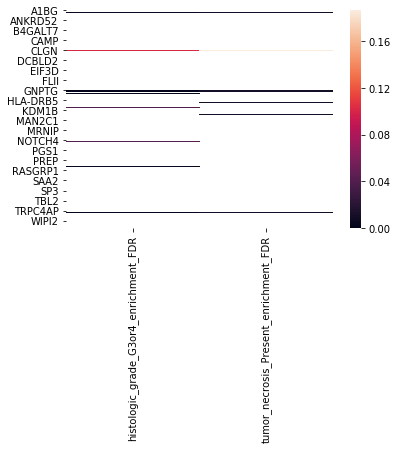

In [233]:
sns.heatmap(results_prot)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [234]:
for col in sig_cols:
    print(col.columns[0])
    print(list(col.index))
    print('\n')

histologic_grade_G3or4_P_values
['ACBD3', 'GOLPH3L', 'GSDME', 'PYCR2', 'TXNRD1']


tumor_necrosis_Present_P_values
['ACBD3', 'GOLPH3L', 'HSP90AB1', 'LARP1', 'TXNRD1']




In [235]:
for col in sig_cols:
    col_name = col.columns[0]
    #col_name = "_".join((col_name.split(" ")))
    print(col_name)
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

histologic_grade_G3or4_P_values


2019-08-13 16:45:20,411 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                             Term Overlap   P-value  \
0  KEGG_2019_Human        Selenocompound metabolism    1/17  0.004243   
1  KEGG_2019_Human  Arginine and proline metabolism    1/49  0.012191   
2  KEGG_2019_Human         Hepatocellular carcinoma   1/168  0.041304   
3  KEGG_2019_Human               Pathways in cancer   1/530  0.125673   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  235.294118   
1               1.0            0                     0   81.632653   
2               1.0            0                     0   23.809524   
3               1.0            0                     0    7.547170   

   Combined Score   Genes  
0     1285.282536  TXNRD1  
1      359.758308   PYCR2  
2       75.876009  TXNRD1  
3       15.653391  TXNRD1  
tumor_necrosis_Present_P_values


2019-08-13 16:45:23,016 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human                    Selenocompound metabolism    1/17   
1   KEGG_2019_Human                           Pathways in cancer   2/530   
2   KEGG_2019_Human          Antigen processing and presentation    1/77   
3   KEGG_2019_Human                      IL-17 signaling pathway    1/93   
4   KEGG_2019_Human                              Prostate cancer    1/97   
5   KEGG_2019_Human      Progesterone-mediated oocyte maturation    1/99   
6   KEGG_2019_Human                    Th17 cell differentiation   1/107   
7   KEGG_2019_Human                   Estrogen signaling pathway   1/137   
8   KEGG_2019_Human       Fluid shear stress and atherosclerosis   1/139   
9   KEGG_2019_Human                                  Necroptosis   1/162   
10  KEGG_2019_Human  Protein processing in endoplasmic reticulum   1/165   
11  KEGG_2019_Human                     Hepatocellular carcinoma   1/168   
12  KEGG_201

In [236]:
dgidb_requests = []

for col in sig_cols:
    sig_genes = list(col.index)
    r = bf.dgidb_get_request(sig_genes)
    dgidb_requests.append(r)
    print('\n')

This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ACBD3,GOLPH3L,GSDME,PYCR2,TXNRD1

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ACBD3,GOLPH3L,HSP90AB1,LARP1,TXNRD1

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs




In [237]:
%%timeit
example = dgidb_requests[1]
matched = example.json().get('matchedTerms')
new_json = {}
new_list = []
for i in matched:
    print('Gene:', i.get('geneName'))
    if len(i.get('interactions')) == 0:
        print('Drugs: None')
    else:
        for item in i.get('interactions'):
            print(item.get('drugName'))
    print('\n')

Gene: ACBD3
Drugs: None


Gene: GOLPH3L
Drugs: None


Gene: HSP90AB1
RETASPIMYCIN
NVP-AUY922
GANETESPIB
TANESPIMYCIN
RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)
ONALESPIB
CHEMBL399530
ALVESPIMYCIN
RADICICOL
GELDANAMYCIN
CHEMBL383189
CHEMBL2204502
CHEMBL553939
CHEMBL113690
CHEMBL2170470


Gene: LARP1
Drugs: None


Gene: TXNRD1
ARSENIC TRIOXIDE
MOTEXAFIN GADOLINIUM
CHEMBL449269
FLAVIN ADENINE DINUCLEOTIDE
SPERMIDINE
FOTEMUSTINE


Gene: ACBD3
Drugs: None


Gene: GOLPH3L
Drugs: None


Gene: HSP90AB1
RETASPIMYCIN
NVP-AUY922
GANETESPIB
TANESPIMYCIN
RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)
ONALESPIB
CHEMBL399530
ALVESPIMYCIN
RADICICOL
GELDANAMYCIN
CHEMBL383189
CHEMBL2204502
CHEMBL553939
CHEMBL113690
CHEMBL2170470


Gene: LARP1
Drugs: None


Gene: TXNRD1
ARSENIC TRIOXIDE
MOTEXAFIN GADOLINIUM
CHEMBL449269
FLAVIN ADENINE DINUCLEOTIDE
SPERMIDINE
FOTEMUSTINE


Gene: ACBD3
Drugs: None


Gene: GOLPH3L
Drugs: None


Gene: HSP90AB1
RETASPIMYCIN
NVP-AUY922
GANETESPIB
TANESPIMYCIN
RETASPIMYCIN HYDROCHLOR

In [238]:
%%timeit
for i, request in enumerate(dgidb_requests):
    print('GENES AND DRUGS FOR: ' + sig_cols[i].columns[0] +':\n')
    drug_dict = bf.dgidb_json_parse(request.json())

GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND 

['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETAS

['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 

['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 

['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 

['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 

['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 

['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 'RETASPIMYCIN HYDROCHLORIDE (CHEMBL377559)', 'ONALESPIB', 'CHEMBL399530', 'ALVESPIMYCIN', 'RADICICOL', 'GELDANAMYCIN', 'CHEMBL383189', 'CHEMBL2204502', 'CHEMBL553939', 'CHEMBL113690', 'CHEMBL2170470']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: histologic_grade_G3or4_P_values:

Gene: PYCR2
Drugs: 
['CHEMBL1161866', 'L-PROLINE']


Gene: TXNRD1
Drugs: 
['ARSENIC TRIOXIDE', 'MOTEXAFIN GADOLINIUM', 'CHEMBL449269', 'FLAVIN ADENINE DINUCLEOTIDE', 'SPERMIDINE', 'FOTEMUSTINE']


GENES AND DRUGS FOR: tumor_necrosis_Present_P_values:

Gene: HSP90AB1
Drugs: 
['RETASPIMYCIN', 'NVP-AUY922', 'GANETESPIB', 'TANESPIMYCIN', 